TODO: 
----- > Motif 

# Layer-wise Relevance Propagation

> This notebooks has five main parts:
> - Introduction to Layer-wise Relevance Propagation
> - Dimensionality reduction
>
>   Following the steps of 04_dr notebooks.
>   - Gets the embeddings (or latent space) from a vultivariate time series given by an encoder (e.g. autoencoder) 
>   - Uses the obtained embeddings as input for a dimensionality reduction algorithm, to generate projections of the embeddings. (As 04.. does)
>
> - Compute Clusters
>   Following the steps of 04_dr notebooks. ¿Maybe it should also be in another notebook?
>   - The projections are clustered via hdbscan 
> - Anomalies simple detector
>   - Use basic statistics to obtain an anomaly score to visualize annomalies using a dynamic plot. Just for clarity.
> - Layer-wise relevance propagation
>   - Different implementations ti apply LRP to check the importance of each feature in the embeddings obtainment.
>   - Same check for selecting some points in the projections plot (assuming random selection). Checks the importance for each feature in the obtainment of the associated part of the embeddings.

> <span style="color:red; display:block;">
>  TODO: Save in 04_... an Artifact as in the previous nbs_pipeline notebooks and divide this notebooks in two (one for clustering and other for layer propagation. ¿Deberíamos separar también 04 en dos notebooks?
> </span>

## Introduction to Layer-wise Relevance Propagation
Layer-wise Relevance Propagation is a XAI technique introduced in 2015 by [Bach et all](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140&ref=blog.paperspace.com) for vision computing deep learning models that has been extensively used in different DL domains for better explainability. 

This method belongs to the attribution methods cattegory. According to [Towards Better Understanding Attribution Methods](https://openaccess.thecvf.com/content/CVPR2022/html/Rao_Towards_Better_Understanding_Attribution_Methods_CVPR_2022_paper.html) and [Oportunities and Challengues in Explainable Artificial Intelligence (XAI): A Survey](https://arxiv.org/pdf/2006.11371.pdf), it can be classified into three main groups: backpropagation based methods, activation based methods and perturbation-based methods.

TODO: Mejorar/revisar
la clasificación con https://arxiv.org/pdf/2006.11371.pdf

### Backpropagation-based or Gradient-based methods
These methods use backpropagation to calculate the relevance of input features, based on each feature's contribution to the model's output. Tipically rely on the gradients:
- with respect to the input
  - [DeepLift: Propagating Activation Differences](https://arxiv.org/abs/1704.02685). Decomposes the oitput prediction of a neural network on a especific input by backpropagating the activation of each neuron to its ```reference activation``` and assigns coontribution scores according to the difference.
  - [Guided BackPropagation/Guided saliency](https://arxiv.org/abs/1412.6806). "Variant of the [deconvolution approach](https://link.springer.com/chapter/10.1007/978-3-319-10590-1_53) for visualizing features learned by CNNs, which can also be applied to a broad range of network structures. Under this approach, the use of max-pooling in convolutional neural networks for small images is questioned and the replacement of max-pooling layers by a convolutional layer with increased stride is proposed, resulting in no loss of accuracy on several image recognition benchmarks." 
- with respect to intermediate layers
  - Saliency Maps. "Visualizing gradients, neural activation of individual layers using DeConv nets, guided backpropagation, etc. as images."
     - [NormGrad](https://openaccess.thecvf.com/content_CVPR_2020/html/Rebuffi_There_and_Back_Again_Revisiting_Backpropagation_Saliency_Methods_CVPR_2020_paper.html). "Based on the spatial contribution of gradients of convolutional weights"
       - Saliency maps combination at different layers to test the ability of saliency methods to extract complementary information at different network levels
        - Class-sensitivity metric and meta-learning inspired paradigm applicable to any saliency method for improving sensitivity to the output class being explained
     - [Compute gradient of the class score with respect to the input case](https://arxiv.org/pdf/1312.6034.pdf). Visualisation techniques for Convolutional Networks used for classification.
     - [Salient Deconvolutional Networks](https://link.springer.com/chapter/10.1007/978-3-319-46466-4_8).
  -  [Salient Relevance Maps](https://sciencedirect.com/science/article/pii/S0262885619300149)
  - [Excitation Backprop](https://link.springer.com/article/10.1007/s11263-017-1059-x). Top-down attention of a CNN classifier for generating task-specific attention map.
  
  - [FullGrad: Full-Gradient Representation for NN Visualization](https://proceedings.neurips.cc/paper/2019/hash/80537a945c7aaa788ccfcdf1b99b5d8f-Abstract.html). Decomposes the NN response into input sensitivity and per-neuron sensitivity components. 
- With respect to the last layer
  - [GradCam](https://openaccess.thecvf.com/content_iccv_2017/html/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.html), [GradCam++](https://ieeexplore.ieee.org/abstract/document/8354201)
- With respect to different layers
  - [LayerCAM: Hierarchical Class Activation Maps](https://ieeexplore.ieee.org/abstract/document/9462463)
  
Also, LRP can be included as a backpropagation-based methods. But it focuses on propagating relevances with different rules instead on focusing on the gradients. 
- [LRP: Layer-wise Relevance Propagation](https://iphome.hhi.de/samek/pdf/MonXAI19.pdf). "Operates by propagating the prediction backward in the neural network, using a set of purposely designed propagation rules".


### Activation-based methods

Weigh activation maps to assign importance of the final convolutional layer:
  - weighted by their gradients:
    - [GradCam](https://openaccess.thecvf.com/content_iccv_2017/html/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.html), [GradCam++](https://ieeexplore.ieee.org/abstract/document/8354201)
    - [LayerCAM: Hierarchical Class Activation Maps](https://ieeexplore.ieee.org/abstract/document/9462463)
    - [Gap CAM: Using Global Average Pooling in CNNs for generating class activation maps](https://openaccess.thecvf.com/content_cvpr_2016/html/Zhou_Learning_Deep_Features_CVPR_2016_paper.html)
  - Estimating their importance to the classification score 
    - [Ablation-cam](https://scholar.google.com/scholar?hl=es&as_sdt=0%2C5&q=Saurabh+Desai+and+Harish+G.+Ramaswamy.+Ablation-CAM%3A+Visual+Explanations+for+Deep+Convolutional+Network+via+Gradient-free+Localization.+In+WACV%2C+pages+983%E2%80%93991%2C+2020.&btnG=). Visual explanations for deep CNN via gradient-free localization. "Uses Ablation analysis to determine the importance (weights) of individual feature map units wrt class. Hilights the important regions in the image for predicting the concept. ..."
    - [Flow restiction](https://arxiv.org/abs/2001.00396), Adds noise to intermediate feature maps to restrict the flow of information and quantify how much information image regions provide.
<span style="color:red">TODO: quizá en TS largas pueda tener sentido algo del estilo aplicar algoritmos menos pesados, comprobar las secciones más relevantes y reducir la serie temporal seleccionando sólo las partes más importantes. </span>
      

### Perturbation-based methods

This methods treat the network as a black-box and assign importance by observing the change in output on perturbing the input. The explanation is generated by iteratively probing a trained ML model with those variations of the input. This can be done using different techniques:

- Occluding parts of the image
  - [Rise: Randomised Input Sampling for Explanation of black-box models](https://arxiv.org/abs/1806.07421). "Generates an importance map indicating how salient each pixel is for the model's prediction." "Estimates importance empirically by proving the model with randomly masked versions of the input image and obtaining the corresponding outputs."
  -  [LIME: Learning and Interpretable Model locally around the prediction](https://dl.acm.org/doi/abs/10.1145/2939672.2939778). "Explains the prediction of any classifier in an interpretable and faithful manner"
  - [Loss derivative back-propagation](https://link.springer.com/chapter/10.1007/978-3-319-10590-1_53). Classification of labelled images. "We train these models using a large set of N labeled images {x,y}, where label y_i is a discrete variable indicating the true class. A cross-entropy loss function, suoitable for image classification, is used to compare ~y_i and u_i. The parameters of the networks are trained by back-propagating the derivative of the loss with respect to the parameters throghout the network, and updating the parameters via stochastic gradient descent"
  - [DeconvNet: DeConvolution networks for convolution visualizations](https://link.springer.com/chapter/10.1007/978-3-319-10590-1_53). Activate the neourons of individual layers by occluding input instance and visualizing using DeConv
Nets.
- Optimising for a mask that maximizes/minimizes class confidence
  - [Real Time Image Saliency for black box classifiers](https://proceedings.neurips.cc/paper_files/paper/2017/hash/0060ef47b12160b9198302ebdb144dcf-Abstract.html). Saliency detection method. 
  - [Interpretable explanation of black boxes by Meaningful Perturbation](https://openaccess.thecvf.com/content_iccv_2017/html/Fong_Interpretable_Explanations_of_ICCV_2017_paper.html). Goal: find the part of an image most responsible for a classifier decision. Model-agnostic and testable. Interpretable image perturbations.

- Selecting specific features
   - [SHAP: A Unified Approach to Interpreting Model Predictions
](https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html) proves feature correlations by removing features in a game theoretic framework.
   - [Prediction Difference Analysis](https://arxiv.org/abs/1702.04595). Remove individual fetures  and finds the positive and negative correlation of individual features towards the output
- Features replacements. [Interpreting Black Box Models via Hypothesis Testing
](https://dl.acm.org/doi/abs/10.1145/3412815.3416889). "Conterfactual replacements of features to study feature importance. 
> TODO: REVISAR el artículo principal. Propone un modo de evaluar algoritmos de atribución. ¿Merece la pena revisarlo? Creo que se sale del scope.

## Dimensionality reduction

Generate projectsion of the embeddings

In [1]:
#Weight & Biases
import wandb

#Yaml
from yaml import load, FullLoader

#Embeddings
from dvats.all import *
from tsai.data.preparation import prepare_forecasting_data
from tsai.data.validation import get_forecasting_splits
from fastcore.all import *

#Dimensionality reduction
from tsai.imports import *

#Clustering
import hdbscan

In [2]:
check_memory_usage = True

In [3]:
if check_memory_usage:
    import nbs_pipeline.utils.memory as mem
    import torch 
    gpu_device = torch.cuda.current_device()
    mem.gpu_memory_status(gpu_device)

GPU | Used mem: 7838
GPU | Used mem: 24576
GPU | Memory Usage: [██████--------------] 32%


In [4]:
#Get W&B API
api = wandb.Api()

### Config parameters

Put here everything that could be needed if this notebook

TODO: Change to config.py & tml version when fixed

In [5]:
## Buscando una combinación buena
cpu_flag = False

if cpu_flag:
    n_neighbors = 15
    min_dist = 0.1
else: 
    n_neighbors = 15 #200
    min_dist = 0.1 #0.0001
    

In [6]:
config = AttrDict(
    use_wandb = False, # Whether to use or not wandb for experiment tracking
    wandb_group = None, # Whether to group this run in a wandb group
    wandb_entity = "mi_santamaria", #"vrodriguezf902", #os.environ['WANDB_ENTITY'], # The entity to use for wandb,
    wandb_project = os.environ['WANDB_PROJECT'], # The project to use for wandb,
    dr_artifact_name = None, # * Set to None for using the default one (encoder validation set)
    #enc_artifact = 'vrodriguezf90/deepvats/mvp:v4', # Name:version of the encoder artifact
    #enc_artifact = 'mi-santamaria/deepvats/mvp:latest', # Name:version of the encoder artifact
    enc_artifact = 'mi-santamaria/deepvats/mvp-SWV:latest', # Name:version of the encoder artifact
    n_neighbors = n_neighbors, #15, #UMAP
    min_dist = min_dist, #0.1, #UMAP,
    random_state = int(1234), # UMAP
    metric = 'euclidean',
    cpu = cpu_flag
)

This model needs to restore the encoder model fitted in the notebook `02x`, as well as the data and configuration

### Run DR

In [7]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="04_dimensionality_reduction"
runname = name
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"

In [8]:
run_dr = wandb.init(
    entity=config.wandb_entity,
    project=config.wandb_project if config.use_wandb else 'work-nbs', 
    group=config.wandb_group,
    allow_val_change=True, 
    job_type='dimensionality_reduction', 
    mode='online' if config.use_wandb else 'disabled',
    anonymous = 'never' if config.use_wandb else 'must',
    config=config,
    resume = 'allow',
    name = runname
    #resume=False
)
config_dr = wandb.config # Object for storing hyperparameters

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/04_dimensionality_reduction.ipynb.


In [9]:
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config_dr.use_wandb else api.artifact

Restore the encoder model and its associated configuration

In [10]:
enc_artifact = artifacts_gettr(config.enc_artifact, type='learner')
enc_artifact.metadata

{'r': 0.7,
 'w': 30,
 'MVP': {'r': 0.7,
  'lm': 3.0,
  'crit': None,
  'sync': False,
  'fname': 'encoder_MVP',
  'dropout': 0.1,
  'verbose': False,
  'stateful': True,
  'save_best': True,
  'nan_to_num': 0,
  'custom_mask': None,
  'future_mask': False,
  'weights_path': None,
  'variable_mask': False,
  'subsequence_mask': True},
 'ref': {'hash': '-4740039002759320942',
  'type': "<class 'fastai.learner.Learner'>"},
 'freq': '1s',
 'alias': 'toy',
 'n_inp': 1,
 'device': 'cuda',
 'epochs': 100,
 'frozen': False,
 'mvp_ws': [10, 30],
 'stride': 1,
 'Learner': {'lr': 0.001,
  'wd': None,
  'arch': 'tsai.models.InceptionTimePlus.InceptionTimePlus',
  'moms': [0.95, 0.85, 0.95],
  'path': '.',
  '_name': '<fastai.learner.Learner object at 0x7fc943a5ac20>',
  'metrics': None,
  'opt_func': 'fastai.optimizer.Adam',
  'splitter': 'tsai.models.utils.ts_splitter',
  'train_bn': True,
  'loss_func': {'axis': -1,
   '_name': {'axis': -1,
    '_name': 'FlattenedLoss of MSELoss()',
    'is_2d':

In [11]:
enc_artifact.name

'mvp-SWV:v66'

In [12]:
enc_artifact.metadata

{'r': 0.7,
 'w': 30,
 'MVP': {'r': 0.7,
  'lm': 3.0,
  'crit': None,
  'sync': False,
  'fname': 'encoder_MVP',
  'dropout': 0.1,
  'verbose': False,
  'stateful': True,
  'save_best': True,
  'nan_to_num': 0,
  'custom_mask': None,
  'future_mask': False,
  'weights_path': None,
  'variable_mask': False,
  'subsequence_mask': True},
 'ref': {'hash': '-4740039002759320942',
  'type': "<class 'fastai.learner.Learner'>"},
 'freq': '1s',
 'alias': 'toy',
 'n_inp': 1,
 'device': 'cuda',
 'epochs': 100,
 'frozen': False,
 'mvp_ws': [10, 30],
 'stride': 1,
 'Learner': {'lr': 0.001,
  'wd': None,
  'arch': 'tsai.models.InceptionTimePlus.InceptionTimePlus',
  'moms': [0.95, 0.85, 0.95],
  'path': '.',
  '_name': '<fastai.learner.Learner object at 0x7fc943a5ac20>',
  'metrics': None,
  'opt_func': 'fastai.optimizer.Adam',
  'splitter': 'tsai.models.utils.ts_splitter',
  'train_bn': True,
  'loss_func': {'axis': -1,
   '_name': {'axis': -1,
    '_name': 'FlattenedLoss of MSELoss()',
    'is_2d':

In [13]:
# TODO: This only works when you run it two timeS! WTF?
try:
    enc_learner = enc_artifact.to_obj()
except:
    enc_learner = enc_artifact.to_obj()

wandb:   1 of 1 files downloaded.  


Restore the dataset artifact used for training the encoder. Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that 
it matches with the dataset that we want to reduce.

In [14]:
enc_logger = enc_artifact.logged_by()
enc_artifact_train = artifacts_gettr(enc_logger.config['train_artifact'], type='dataset')
if enc_logger.config['valid_artifact'] is not None:
    enc_artifact_valid = artifacts_gettr(enc_logger.config['valid_artifact'], type='dataset')
    print("enc_artifact_valid:", enc_artifact_valid.name)
print("enc_artifact_train: ", enc_artifact_train.name)

enc_artifact_train:  toy:v2


Now we specify the dataset artifact that we want to use for the reduction. If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [15]:
if config_dr.dr_artifact_name is not None:
    dr_artifact = artifacts_gettr(config_dr.dr_artifact_name)
else:
    dr_artifact = enc_artifact_train
dr_artifact.name

'toy:v2'

Now we need to check whether the artifact that is going to be used fort the dimensionality reduction matches the artifact used to train the encoder. Matching means having the same number of variables, the same window size and stride, and the same frequency.

In [16]:
df = dr_artifact.to_df()
df.head()

wandb:   1 of 1 files downloaded.  


,T3,T2,T1
1970-01-01 00:00:00,0.741822,0.637180,0.565117
1970-01-01 00:00:01,0.739731,0.629415,0.493513
1970-01-01 00:00:02,0.718757,0.539220,0.469350
1970-01-01 00:00:03,0.730169,0.577670,0.444100
1970-01-01 00:00:04,0.752406,0.570180,0.373008


In [17]:
type(df)

pandas.core.frame.DataFrame

In [18]:
print(df.shape)
print(np.round(df.shape[0]/ 1e6, 1))
print(np.round(df.shape[0]/ 1e3, 1))

(550, 3)
0.0
0.6


In [19]:
show_time_series_flag = False
if show_time_series_flag:
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [20]:
import time

In [21]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

GPU | Used mem: 7838
GPU | Used mem: 24576
GPU | Memory Usage: [██████--------------] 32%


In [22]:
w = enc_artifact.metadata['w']
t_start = time.time()
enc_input, _ = prepare_forecasting_data(df, fcst_history = w)
t_end = time.time()
t = t_end - t_start
print("SW start | " , t_start, " | end ", t_end, "total (secs): ", t)
print(enc_input.shape)

SW start |  1707126307.948136  | end  1707126307.9488835 total (secs):  0.0007474422454833984
(520, 3, 30)


In [23]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

GPU | Used mem: 7838
GPU | Used mem: 24576
GPU | Memory Usage: [██████--------------] 32%


### Getting the embeddings (activations) from the encoder

In [24]:
stride = enc_logger.config['stride']
batch_size = enc_logger.config['batch_size']

##### Check de toy ####
stride = 5
####

In [25]:
print(stride)
print(batch_size)

5
32


In [26]:
print(enc_input.shape)
print(enc_artifact.name)

(520, 3, 30)
mvp-SWV:v66


In [27]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

GPU | Used mem: 7838
GPU | Used mem: 24576
GPU | Memory Usage: [██████--------------] 32%


In [28]:
chunk_max = 10000000
shape = enc_input.shape
chunk_size_ = min(shape[1]*shape[2],chunk_max/(shape[1]*shape[2]))
N = max(3200,np.floor(chunk_size_/32))
chunk_size = N*32
chunk_size

102400

In [29]:
t_start = time.time()
embs = get_enc_embs_set_stride_set_batch_size(
    enc_input, 
    enc_learner, 
    stride = stride,
    batch_size = batch_size,
    cpu=config.cpu,
    to_numpy = True, 
    print_flag = False,
    time_flag = True,
    chunk_size = chunk_size
)
t_end = time.time()
t = t_end-t_start
print("GE start | " , t_start, " | end ", t_end, "total (secs): ", t)

get_enc_embs_set_stride_set_batch_size 0.7542128562927246 seconds
GE start |  1707126308.1887467  | end  1707126308.943905 total (secs):  0.7551584243774414


In [30]:
beep(0.05)

In [31]:
embs.shape

(104, 128)

In [32]:
embs[0,0:20]

array([0.33592895, 0.        , 0.18003725, 0.        , 0.4662698 ,
       0.696591  , 0.25043887, 0.49783897, 0.        , 0.        ,
       0.        , 0.41448307, 0.        , 0.        , 0.12928401,
       0.        , 0.06615641, 0.        , 0.08677851, 0.        ],
      dtype=float32)

In [33]:
t_end = time.time()
t = t_end-t_start
print("GE start | " , t_start, " | end (next cell) ", t_end, "total (secs): ", t)

GE start |  1707126308.1887467  | end (next cell)  1707126309.9879541 total (secs):  1.7992074489593506


In [34]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

GPU | Used mem: 7838
GPU | Used mem: 24576
GPU | Memory Usage: [██████--------------] 32%


In [35]:
run_dr.finish()

In [36]:
#Restart kernel (Debugging code 4 analysing where can app be failing. Expecting to be related to GPU mem ussage)
#os._exit(00)

### Dimensions check

In [37]:
print(embs.shape)
print(enc_input.shape)

(104, 128)
(520, 3, 30)


In [38]:
embs[0][:10]

array([0.33592895, 0.        , 0.18003725, 0.        , 0.4662698 ,
       0.696591  , 0.25043887, 0.49783897, 0.        , 0.        ],
      dtype=float32)

In [39]:
#Dimensions check
num_inputs = np.ceil(enc_input.shape[0]/stride)
num_embs = embs.shape[0]
test_eq(num_inputs, num_embs )
print(num_inputs, num_embs)

104.0 104


Average embeddings in the time dimension, if needed

## Dimensionality reduction using UMAP

We use DR techniques to provide an alternative view for users to visually analyze and explore the time-series data. The algorithm UMAP shows its high competitiveness compared to t-SNE. t-SNE suffers from some limitations such as loss of large-scale information (the inter-cluster relationships). UMAP has a faster runtime and provides better scaling which helps to gain a meaningful organization of clusters, outliers and the preservation of continuums compared to t-SNE

For this part of the implementation, the package [umap-learn](https://github.com/lmcinnes/umap) is used. The input of the algoritm is the $n \times \delta$ that contains, for each slice of the time series, the corresponding $\delta$ latent embeddings given by the encoder.

The hyperparameters of UMAP are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [40]:
if cpu_flag:
    umap_params = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), #np.uint64(1234), 
        'metric': config_dr.metric,
        'a': 1.5769434601962196,
        'b': 0.8950608779914887,
        #'metric_kwds': {'p': 2}, #No debería ser necesario, just in case
        'output_metric': 'euclidean',
        'verbose': 4,
        'n_epochs': 200
    }
else:
    umap_params = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(822569775), #np.uint64(1234),
        'metric': config_dr.metric,
        'a': 1.5769434601962196,
        'b': 0.8950608779914887,
        'target_metric': 'euclidean',
        'target_n_neighbors': config_dr.n_neighbors,
        'verbose': 6,
        'n_epochs': 200
    }






check_reducer = True
import utils.config as cfg_
if check_reducer:
    import umap
    import cuml
    print("-- umap.UMAP --", cpu_flag)
    reducer1 = umap.UMAP(force_approximation_algorithm = True, **umap_params)
    print("-- cuml.UMAP --", cpu_flag)
    reducer2 = cuml.UMAP(**umap_params)
    print("------- reducer1 --------")
    print(reducer1)
    params1=AttrDict(reducer1.get_params())
    print("------- reducer2 --------")
    print(reducer2)
    params2=AttrDict(reducer2.get_params())
    print("------- reducer2 --------")
    cfg_.diff_attrdict(dict_original=params2, dict_modified=params1, both=True)
    beep(0.10)

#if not cpu_flag:
    #umap_params['force_approximation_algorithm'] = True # Este no parece ser el influencer
    #umap_params['angular_rp_forest'] = True #No es el influencer

#if params2['random_state'] != 1234:
 #   raise Exception("Wrong random_state params")

-- umap.UMAP -- False
-- cuml.UMAP -- False
------- reducer1 --------
UMAP(a=1.5769434601962196, b=0.8950608779914887, force_approximation_algorithm=True, n_epochs=200, random_state=822569775, target_metric='euclidean', target_n_neighbors=15, verbose=6)
------- reducer2 --------
UMAP()
------- reducer2 --------
handle is missing in modified dict | 0 
dens_var_shift is missing in original dict | 0.1 
local_connectivity: 1.0
disconnection_distance is missing in original dict | None 
random_state: 822569775
tqdm_kwds is missing in original dict | None 
transform_queue_size: 4.0
hash_input is missing in modified dict | 0 
unique is missing in original dict | False 
callback is missing in modified dict | 0 
min_dist: 0.1
transform_mode is missing in original dict | embedding 
target_metric_kwds is missing in original dict | None 
metric: euclidean
learning_rate: 1.0
precomputed_knn: None -> (None, None, None)
verbose: 6
dens_frac is missing in original dict | 0.3 
target_n_neighbors: 15
for

In [41]:
#Ensure no nan ((Intento de Macu. La celda de comentada abajo es la original. Pero falla por Nan con sunspot))
embs_no_nan = embs[~np.isnan(embs).any(axis=1)]
embs_no_nan.shape

(104, 128)

In [42]:
umap_params_cpu = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(822569775), 
        'metric': config_dr.metric,
        #'a': 1.5769434601962196,
        #'b': 0.8950608779914887,
        #'metric_kwds': {'p': 2}, #No debería ser necesario, just in case
        #'output_metric': 'euclidean',
        'verbose': 4,
        #'n_epochs': 200
    }
umap_params_gpu = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        'a': 1.5769434601962196,
        'b': 0.8950608779914887,
        'target_metric': 'euclidean',
        'target_n_neighbors': config_dr.n_neighbors,
        'verbose': 4, #6, #CUML_LEVEL_TRACE
        'n_epochs': 200*3*2,
        'init': 'random',
        'hash_input': True
    }


if cpu_flag:
    umap_params = umap_params_cpu
else:
    umap_params = umap_params_gpu

umap_params


{'n_neighbors': 15,
 'min_dist': 0.1,
 'random_state': 1234,
 'metric': 'euclidean',
 'a': 1.5769434601962196,
 'b': 0.8950608779914887,
 'target_metric': 'euclidean',
 'target_n_neighbors': 15,
 'verbose': 4,
 'n_epochs': 1200,
 'init': 'random',
 'hash_input': True}

In [43]:
embs_no_nan.shape

(104, 128)

In [44]:
prjs_pca = get_PCA_prjs(
    X = embs_no_nan, 
    cpu = False, #cpu_flag, #config_dr.cpu, 
    print_flag = True, 
    #target_weight=1,
    **umap_params
)
prjs_pca.shape

[I] [09:45:11.289594] Unused keyword parameter: print_flag during cuML estimator initialization
[I] [09:45:11.289944] Unused keyword parameter: n_neighbors during cuML estimator initialization
[I] [09:45:11.290133] Unused keyword parameter: min_dist during cuML estimator initialization
[I] [09:45:11.290335] Unused keyword parameter: metric during cuML estimator initialization
[I] [09:45:11.290520] Unused keyword parameter: a during cuML estimator initialization
[I] [09:45:11.290706] Unused keyword parameter: b during cuML estimator initialization
[I] [09:45:11.290882] Unused keyword parameter: target_metric during cuML estimator initialization
[I] [09:45:11.291063] Unused keyword parameter: target_n_neighbors during cuML estimator initialization
[I] [09:45:11.291244] Unused keyword parameter: n_epochs during cuML estimator initialization
[I] [09:45:11.291420] Unused keyword parameter: init during cuML estimator initialization
[I] [09:45:11.291596] Unused keyword parameter: hash_input d

(104, 104)

In [45]:
prjs_umap = get_UMAP_prjs(
    input_data = prjs_pca, 
    cpu =  cpu_flag, #config_dr.cpu, 
    print_flag = True, 
    #target_weight=1,
    **umap_params
)
prjs_umap.shape

--> get_UMAP_prjs
kwargs:  {'n_neighbors': 15, 'min_dist': 0.1, 'random_state': 1234, 'metric': 'euclidean', 'a': 1.5769434601962196, 'b': 0.8950608779914887, 'target_metric': 'euclidean', 'target_n_neighbors': 15, 'verbose': 4, 'n_epochs': 1200, 'init': 'random', 'hash_input': True}
549b35496d635ca4a9356ff79be66e01
GPU | Used mem: 7838
GPU | Used mem: 24576
GPU | Memory Usage: [██████--------------] 32%
-- cuml.UMAP -- False
------- reducer --------
UMAP()
{'handle': <pylibraft.common.handle.Handle object at 0x7fb884d90d80>, 'verbose': 4, 'output_type': 'input', 'n_neighbors': 15, 'n_components': 2, 'n_epochs': 1200, 'learning_rate': 1.0, 'min_dist': 0.1, 'spread': 1.0, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1.0, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'init': 'random', 'a': 1.5769434601962196, 'b': 0.8950608779914887, 'target_n_neighbors': 15, 'target_weight': 0.5, 'target_metric': 'euclidean', 'hash_input': True, 'random_state': 123

(104, 2)

In [46]:
beep(0.15)
beep(0.15)
beep(0.15)


In [47]:
prjs_umap[0:10] # En R head(res[1,],10)

array([[-1.9913254, -4.059066 ],
       [-2.224599 , -3.8410072],
       [-2.4595137, -3.5813437],
       [-2.5522337, -3.342784 ],
       [-2.6423607, -3.364974 ],
       [-2.8024044, -3.4382343],
       [-2.7203064, -3.409813 ],
       [-2.9209728, -3.1903877],
       [-2.7954264, -2.9880285],
       [-3.2627048, -1.0129414]], dtype=float32)

In [48]:
#prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)
#prjs.shape

Save the projections as an artifact

In [49]:
if config.use_wandb: 
    run.log_artifact(ReferenceArtifact(prjs, 'projections', type='projections', 
metadata=dict(run_dr.config)), aliases=f'run-{run.project}-{run.id}')

## Create Precomputed Clusters

In order to integrate precomputed clusters into the embedding space, it's necessary to log artifacts that include the labels of the newly created clusters. 

The cluster creation process is presented below. This creation procedure can be modified according to specific needs. However, the structure of the new artifact must be preserved (it must be a numpy.ndarray and the number of elements must be equal to the number of points in the embedding space).

In [50]:
print(f'HDBSCAN supported metrics: {list(hdbscan.dist_metrics.METRIC_MAPPING.keys())}')

HDBSCAN supported metrics: ['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'cosine', 'arccos', 'pyfunc']


In [51]:
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 7, #100, #100,
    'min_samples' : 3,
    'cluster_selection_epsilon' : 0.0001,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard'
}

In [52]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_umap)
clusters_labels = clusters.labels_
list(Counter(clusters_labels).items())

[(3, 15), (4, 8), (-1, 5), (6, 12), (5, 15), (2, 9), (0, 22), (1, 18)]

### Check cluster score

In [53]:
score = cluster_score(prjs_umap, clusters_labels, True)

Silhouette_score: 0.57026136


In [54]:
# Testing artifact structure 
test_eq_type(type(clusters_labels), np.ndarray)
test_eq(clusters_labels.size, prjs_umap.shape[0])

In [55]:
# Create and log 'clusters_labels' artifact
clusters_ar = ReferenceArtifact(obj=clusters_labels, name='clusters_labels')
clusters_ar.metadata, clusters_ar.manifest.entries.values()

({'ref': {'hash': '-3390740367276432939', 'type': "<class 'numpy.ndarray'>"}},
 dict_values([ArtifactManifestEntry(path='-3390740367276432939', digest='JU7SLW72Ou1KF7Yw0pZV8w==', ref='file:///home/macu/data/wandb_artifacts/-3390740367276432939', birth_artifact_id=None, size=982, extra={}, local_path=None)]))

In [56]:
run_dr.log_artifact(clusters_ar, aliases=['hdbscan_jaccard'])

## 2D Visualization 

While the connected scatter plot is a simple visualization technique, it has very specific functions in our approach. Every sliding window is represented as a dot in the plot after the projection process (Fig. 4C, D of the paper). Before labeling, all points have the same color and transparency, and when they are concentrated in one area, the densities are accumulated. Lines are used to connect consecutive points preserving the temporal ordering of the data and allowing the user to see temporal connections (Fig. 4B of the paper). Thus, the point is linked to the previous point (inner) and to the posterior point (outer) as an indication of the flow of time.

In [57]:
#| export
def plot_projections(prjs, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

In [58]:
#| export
def plot_projections_clusters(prjs, clusters_labels, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    df_prjs['cluster'] = clusters_labels
    
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    
    # Create a scatter plot for each cluster with different colors
    unique_labels = df_prjs['cluster'].unique()
    print(unique_labels)
    for label in unique_labels:
        cluster_data = df_prjs[df_prjs['cluster'] == label]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {label}')
        #ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    
    #ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

[ 3  4 -1  6  5  2  0  1]


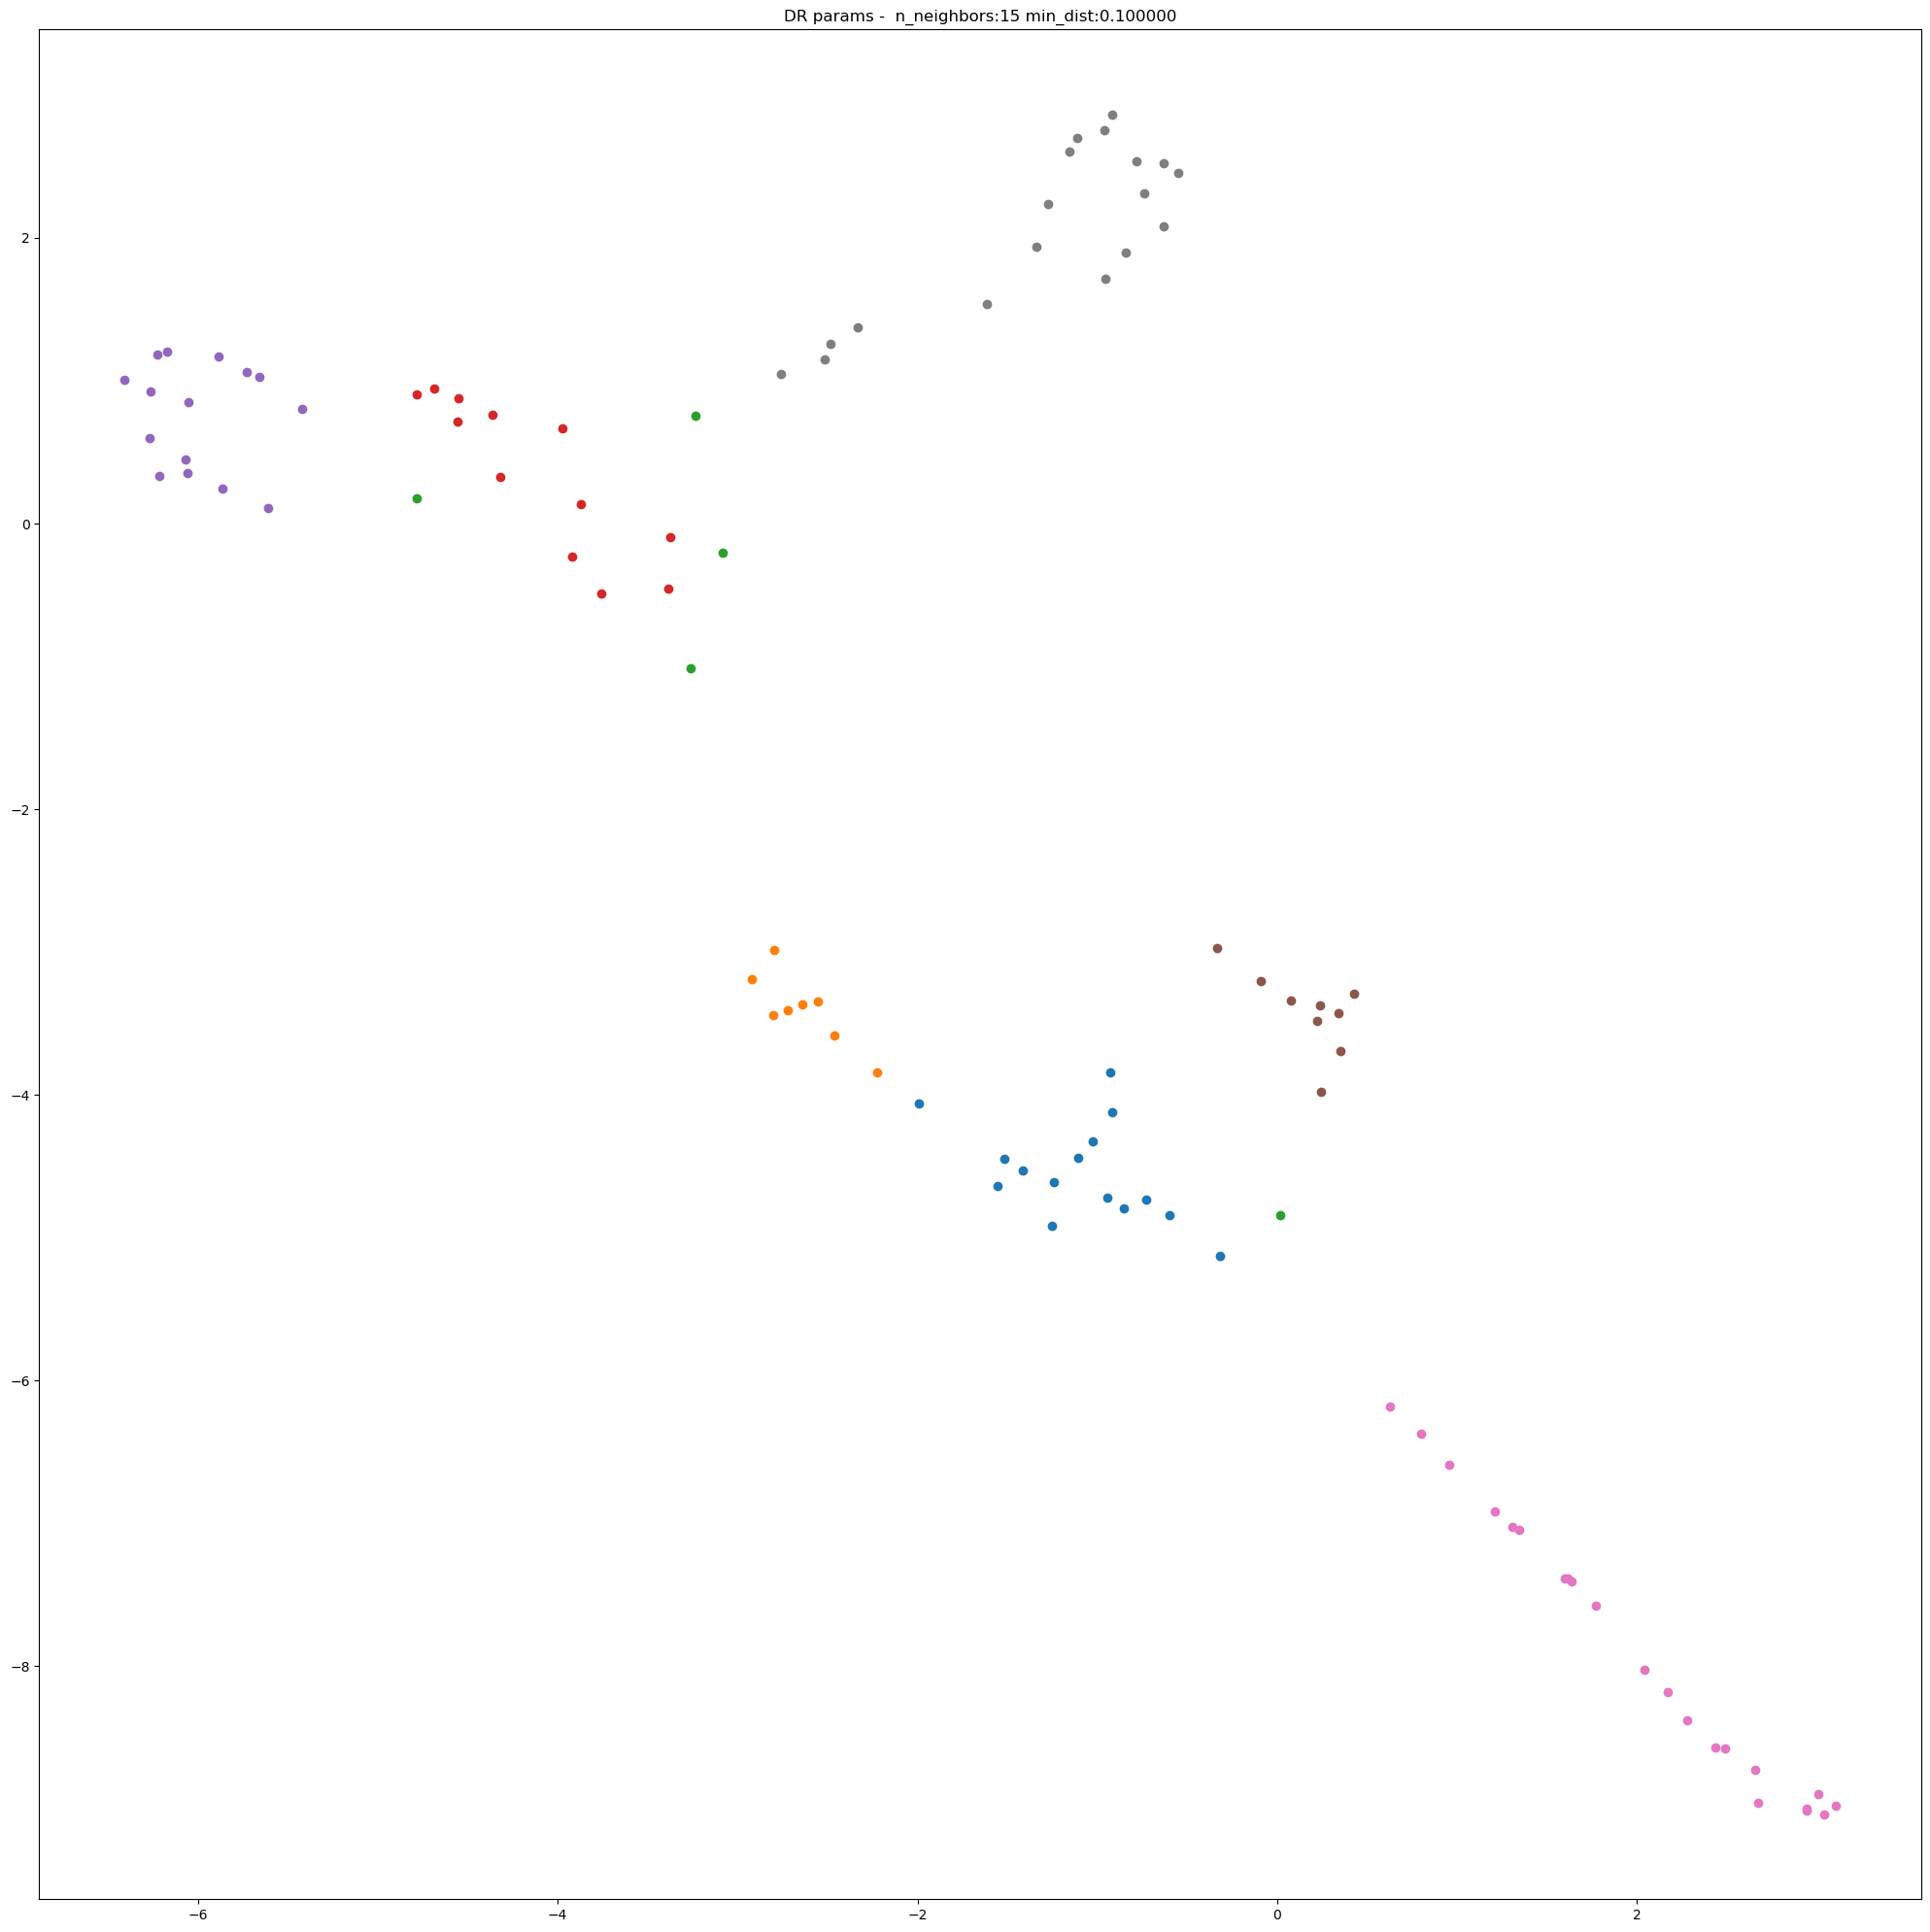

In [59]:
prjs_plt = plot_projections_clusters(prjs_umap, clusters_labels, umap_params)

In [60]:
beep(0.25)
beep(0.25)
beep(0.25)

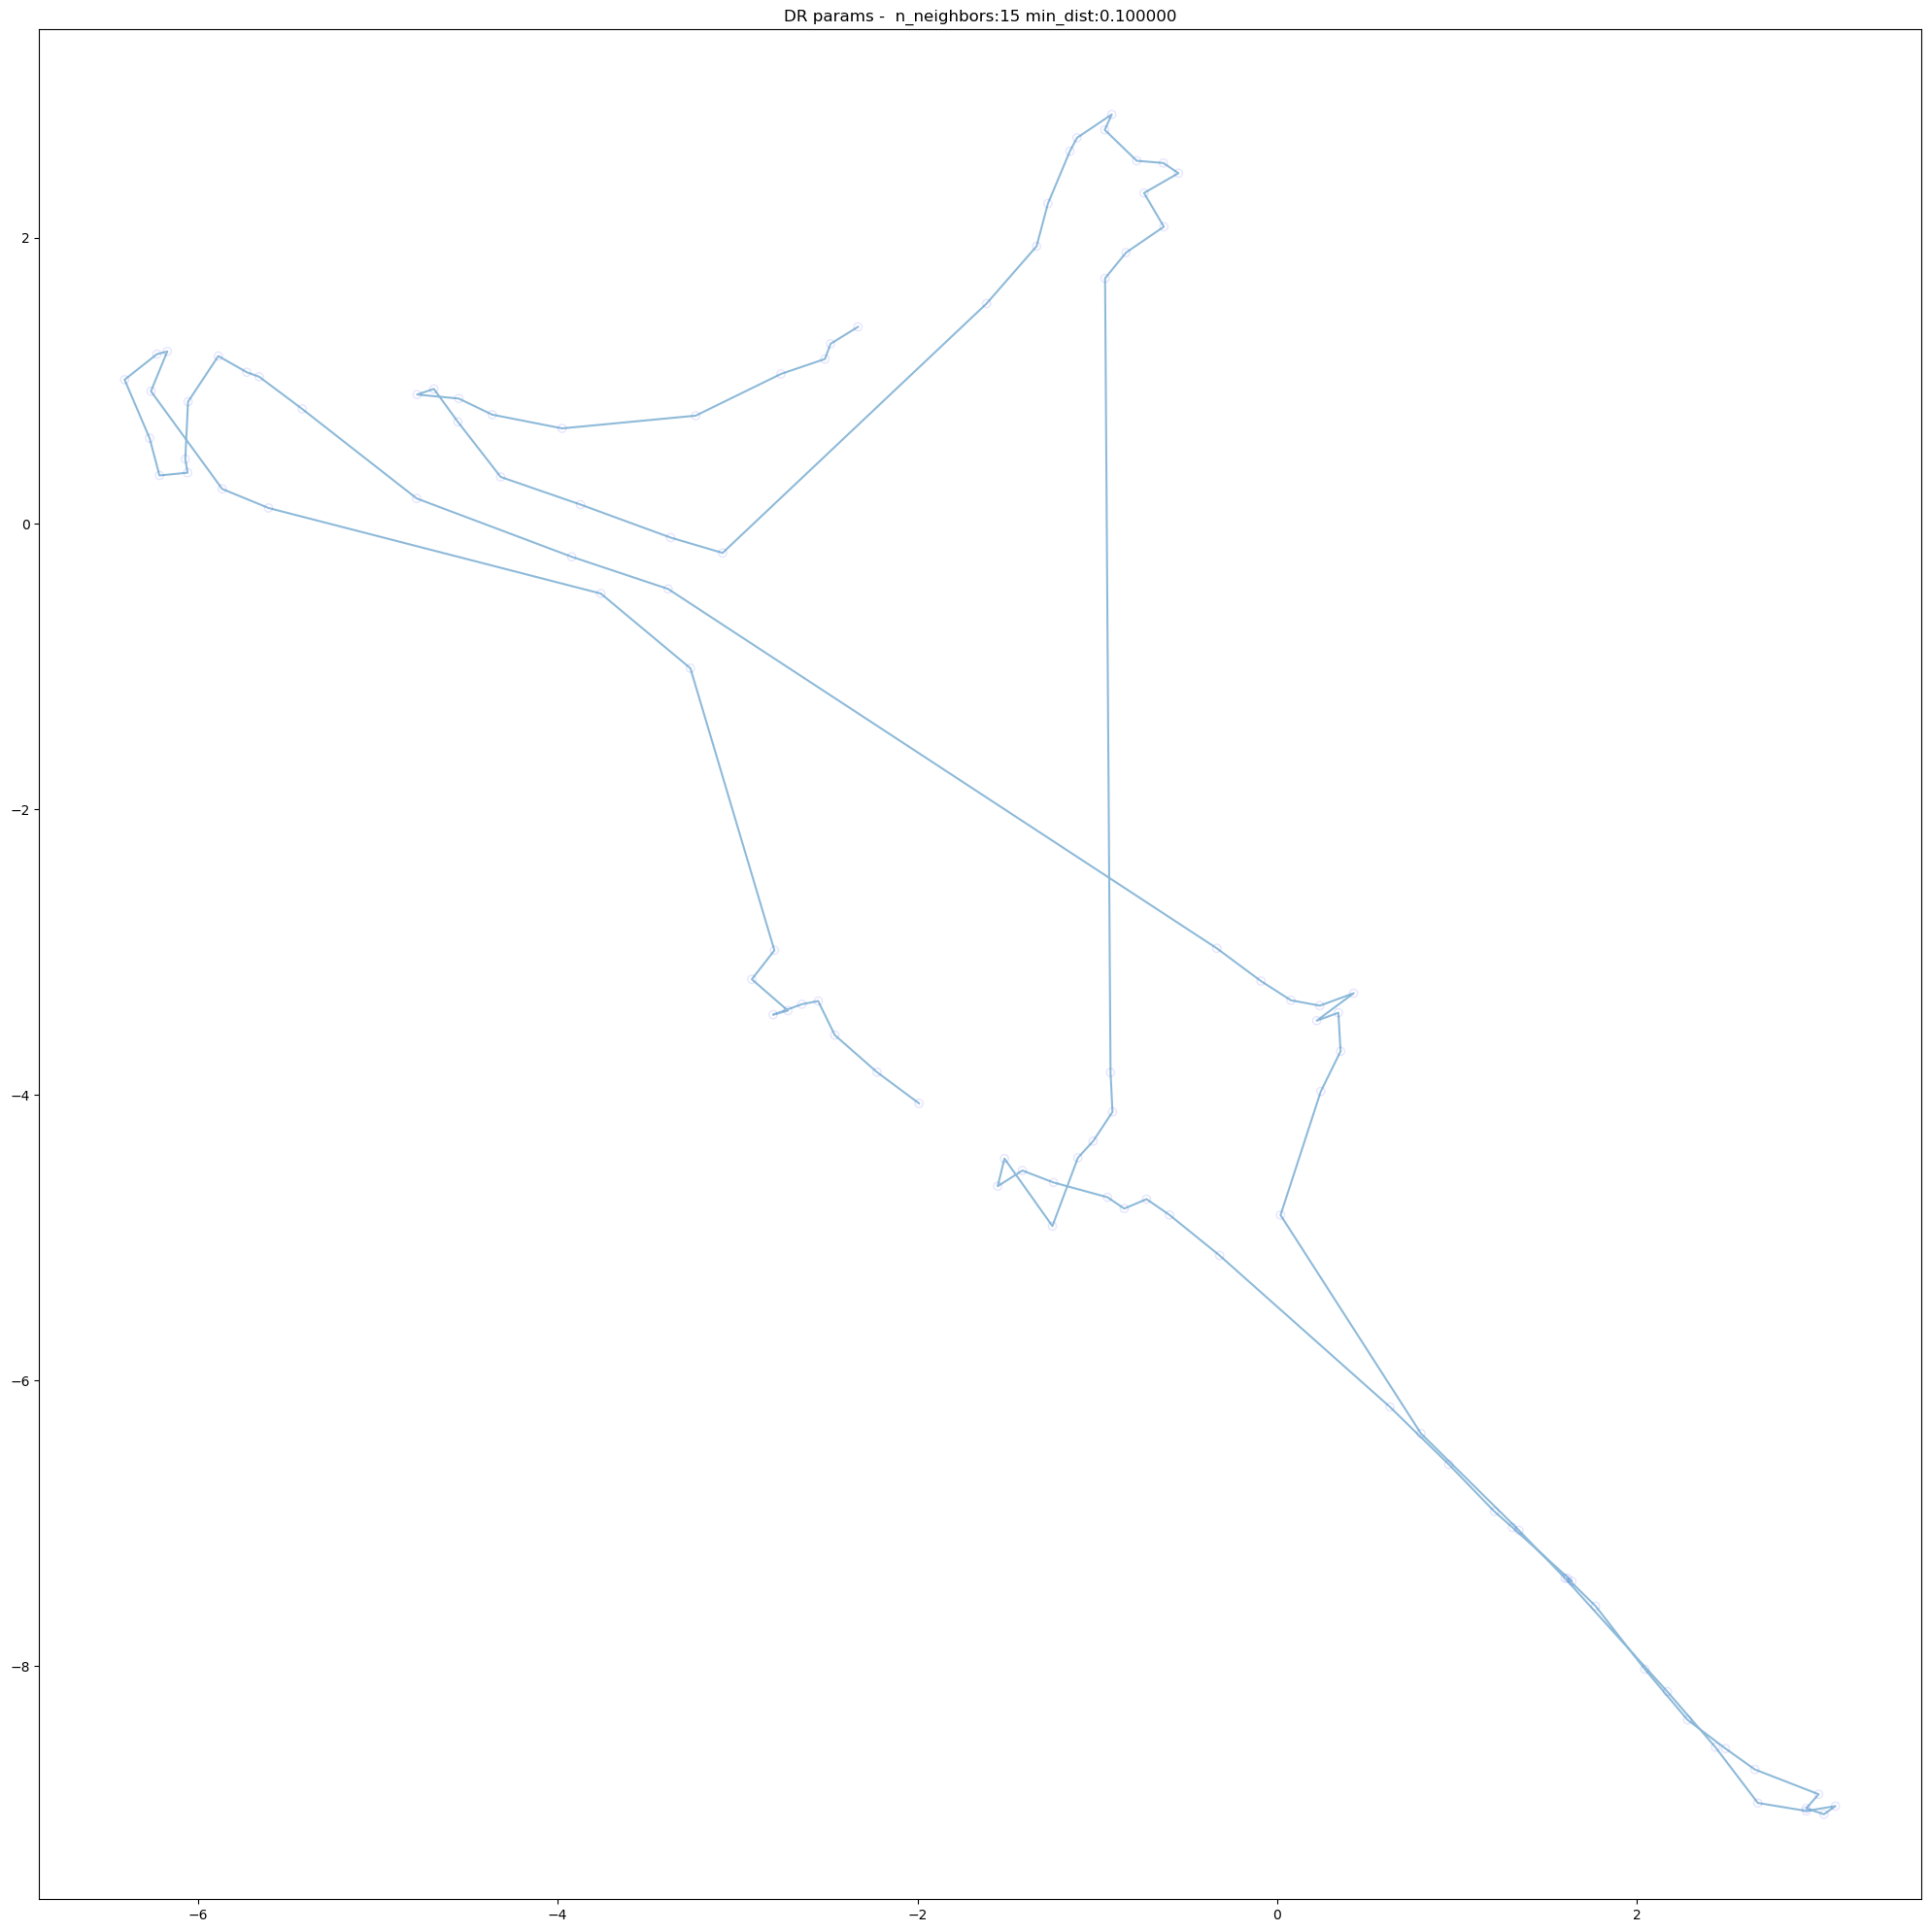

In [61]:
prjs_plt = plot_projections(prjs_umap, umap_params)

Log this plot as part of the current wandb run

In [62]:
#| hide

# Get the figure of the embedding plot, and save it on thea wandb run.
run_dr.log({"img": [wandb.Image(prjs_plt.get_figure(), caption="dr_projections_plot")]})

#run_dr.log({'embeddings_plot': embeddings_plot})

In [63]:
#| hide
run_dr.finish()

## Anomalies simple detector: dynamic plot for determining whether a window of time series is anomalous

#### Get Anomaly Score

In [64]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_umap)
clusters_labels = clusters.labels_
list(Counter(clusters_labels).items())

[(3, 15), (4, 8), (-1, 5), (6, 12), (5, 15), (2, 9), (0, 22), (1, 18)]

In [65]:
def calculate_cluster_stats(data, labels):
    """Computes the media and the standard deviation for every cluster."""
    cluster_stats = {}
    for label in np.unique(labels):
        #members = data[labels == label]
        members = data
        mean = np.mean(members, axis = 0)
        std = np.std(members, axis = 0)
        cluster_stats[label] = (mean, std)
    return cluster_stats

In [66]:
def anomaly_score(point, cluster_stats, label):
    """Computes an anomaly score for each point."""
    mean, std = cluster_stats[label]
    return np.linalg.norm((point - mean) / std)

In [67]:
def detector(data, labels):
    """Anomaly detection function."""
    cluster_stats = calculate_cluster_stats(data, labels)
    scores = []
    for point, label in zip(data, labels):
        score = anomaly_score(point, cluster_stats, label)
        scores.append(score)
    return np.array(scores)

In [68]:
anomaly_scores = detector(prjs_umap, clusters_labels)

### Check anomaly scores distribution

In [69]:
def plot_anomaly_scores_distribution(anomaly_scores):
    "Plot the distribution of anomaly scores to check for normality"
    plt.figure(figsize=(10, 6))
    sns.histplot(anomaly_scores, kde=True, bins=30)
    plt.title("Distribución de Anomaly Scores")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frecuencia")
    plt.show()

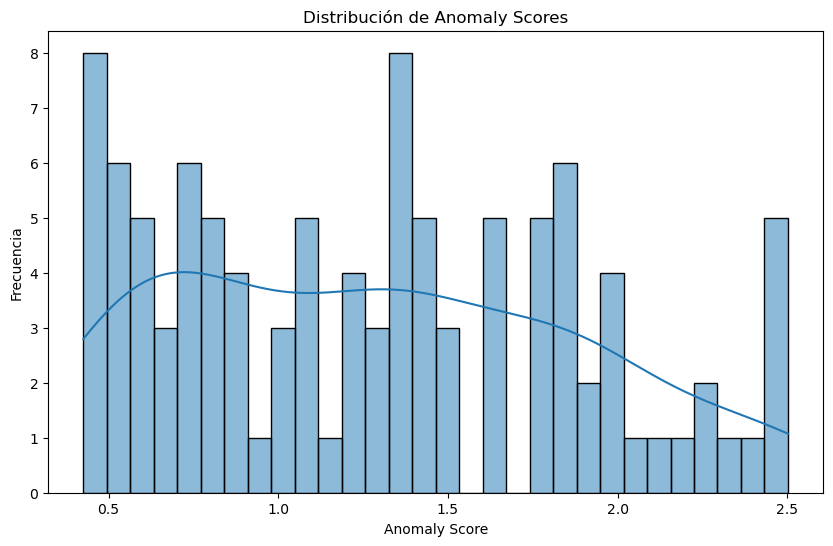

In [70]:
import seaborn as sns
plot_anomaly_scores_distribution(anomaly_scores)

## Select a threshold

In [71]:
print(anomaly_scores.shape)
print("min ", np.min(anomaly_scores))
print("max ", np.max(anomaly_scores))
anomaly_scores_mean = np.mean(anomaly_scores)
print("media ", anomaly_scores_mean)
anomaly_scores_std = np.std(anomaly_scores)
print("std ", anomaly_scores_std)

(104,)
min  0.42555267
max  2.5017462
media  1.2830617
std  0.5947709


In [72]:
num_std = 2
threshold = anomaly_scores_mean + num_std * anomaly_scores_std
print("Threshold: ", threshold)

Threshold:  2.4726035594940186


### Plot the anomalies

In [73]:
#| export
def plot_clusters_with_anomalies(prjs, clusters_labels, anomaly_scores, threshold, fig_size=(25, 25)):
    "Plot 2D projections of clusters and superimpose anomalies"
    df_prjs = pd.DataFrame(prjs, columns=['x1', 'x2'])
    df_prjs['cluster'] = clusters_labels
    df_prjs['anomaly'] = anomaly_scores > threshold

    fig = plt.figure(figsize=(fig_size[0], fig_size[1]))
    ax = fig.add_subplot(111)

    # Plot each cluster with different colors
    unique_labels = df_prjs['cluster'].unique()
    for label in unique_labels:
        cluster_data = df_prjs[df_prjs['cluster'] == label]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {label}', alpha=0.7)

    # Superimpose anomalies
    anomalies = df_prjs[df_prjs['anomaly']]
    ax.scatter(anomalies['x1'], anomalies['x2'], color='red', label='Anomalies', edgecolor='k', s=50)

    plt.title('Clusters and anomalies')
    plt.legend()
    plt.show()


In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from functools import partial
fig_size = (7,7)
def update_plot(threshold):
    plot_clusters_with_anomalies(prjs_umap, clusters_labels, anomaly_scores, threshold, fig_size)

In [75]:
threshold_slider = widgets.FloatSlider(value=2, min=1, max=3, step=0.01, description='Threshold')
widgets.interactive(update_plot, threshold=threshold_slider)

interactive(children=(FloatSlider(value=2.0, description='Threshold', max=3.0, min=1.0, step=0.01), Output()),…

#### Using quartiles for the scores

In [76]:
def detect_anomalies_using_iqr(scores):
    # First and third quartiles
    Q1 = np.percentile(scores, 25)
    Q3 = np.percentile(scores, 75)
    # IQR range
    IQR = Q3 - Q1
    
    #Limits for anomalies
    factor = 1.5
    lower_bound = Q1 - (factor * IQR)
    upper_bound = Q3 + (factor * IQR)
    
    # Get anomalies
    anomalies = (scores < lower_bound) | (scores > upper_bound)
    
    return anomalies, lower_bound, upper_bound

In [77]:
anomalies, lower_bound, upper_bound = detect_anomalies_using_iqr(anomaly_scores)

print("Lower Bound for Anomalies:", lower_bound)
print("Upper Bound for Anomalies:", upper_bound)

Lower Bound for Anomalies: -0.8447956368327141
Upper Bound for Anomalies: 3.3884134367108345


In [78]:
def plot_data_with_anomalies(data, anomalies):
    plt.scatter(data[:, 0], data[:, 1], color='blue', label='Normal Data')
    plt.scatter(data[anomalies, 0], data[anomalies, 1], color='red', label='Anomalies')
    plt.title('Data with Anomalies highlighted')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

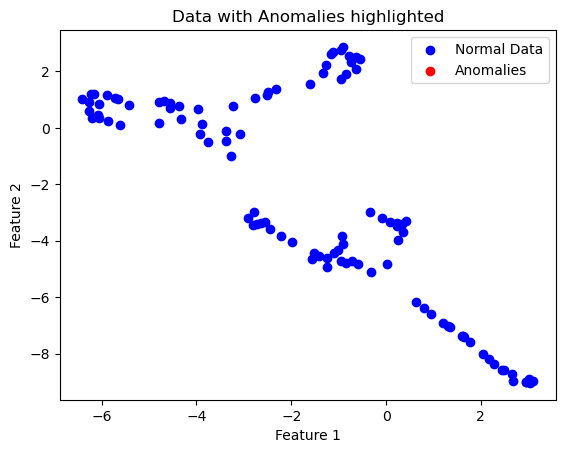

In [79]:
plot_data_with_anomalies(prjs_umap, anomalies)

## LRP

LRP is a technique of explainable artifficial intelligence (XAI). It is used to explain the predictions of models that are structured as neural networks. It operates by backpropagating the prediction in the neural network using a set of designed local ```propagation rules```.

### LRP structure

- Define the Neural Network (NN) model. It will be composed by different layers, each one wich its own neurons.
- Backpropagation
  - Propagation starts at the top layer (usually, the output layer of the NN)
  - Local Propagation Rules

    In each neuron, specific local ```propagation rules``` are applied to calculate how much ```relevance``` or importance should be passed to the next layer. The ```relevance``` is a real number defined via the ```propagation rule```.
  - Propagation
  
    The relevances calculated in the layer are transmitted downwards to the next layer.

      - Conservation property: the total amount of relevance received by each neuron is equally redistributed to the neurons in the layer bellow.
  - Repeat layer by layer. The propagation continues until it reaches the input features of the NN. At this point, each input feature has received a relevance score that reflects its contribution to the NN prediction. 
   


### Comparison with other techniques
LRP distinguishes itself from other explainability techniques in two ways:
- Other techniques are often more computationally expensive, as many of them involve multiple neural network evaluations.
- Some alternative techniques replace the gradient with a coarser estimate of effect. That involves optimising some local surrogate model or the explanation itself.

In contrast, LRP leverages the graph structure of deep neural networks to compute explanations quickly and reliably​​.

### Limitations

The main limitation of LRP is the way it handles features' contributions. The method for dealing with positive and negative contributions during the propagation phase may limit how much these relevances can grow. 

This may result on less detailed representation of how the input features may affect to the NN output. However, this aids in providing more stable explanations. 

Also, this mean that LRP is more focused on global trend or most influence features instead of granulated details or minor variations... 

...**and that is exactly what we are looking for here!** 

Great!

### LRP implementations
In order to decide a library for implementing LRP into deepvats, ```GitHub``` and ```PyPI``` available libraries have been checked.
ctions) |


| Library | GitHub URL | Base Framework | Supported Data Types | Associated Paper |
|---------|------------|----------------|----------------------|------------------|
| iNNvestigate | [GitHub](https://github.com/albermax/innvestigate) [PyPI](https://pypi.org/project/innvestigate/)| Various (Keras, TensorFlow, PyTorch - added in 2019) | Not specified. The paper talks about pixels and classifiers. Assumed to be used for vision classification models | [Paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140&ref=blog.paperspace.com) |
| Zennit | [PyPI](https://pypi.org/project/zennit/) | PyTorch | Not specified (Adaptable to different data types) | [Paper](https://arxiv.org/abs/2106.13200) |
| PyTorchRelevancePropagation | [GitHub](https://github.com/kaifishr/PyTorchRelevancePropagation) | PyTorch | Not specified | Not available |
| TorchLRP | [GitHub](https://github.com/fhvilshoj/TorchLRP) | PyTorch | Not specified | Not available, not in PyPI => Not relevant for this study|
| Layerwise-Relevance-Propagation-for-LSTMs | [GitHub](https://github.com/alewarne/Layerwise-Relevance-Propagation-for-LSTMs) | TensorFlow | Time Series (Specifically for LSTMs) | Not available |
| LRP Toolbox | [GitHub](https://github.com/sebastian-lapuschkin/lrp_toolbox) | Matlab, Python (no PyTorch in requirements), Caffe | Not specified. Examples show images and text. | Not available |
| lrp-pf-auc | [PyPI](https://pypi.org/project/lrp-pf-auc/) [Zenodo](https://zenodo.org/records/6821295) | Python (no PyTorch in requirements) | Not specified | Not available |
| keras-explain | [PyPI](https://pypi.org/project/keras-explain/) | Keras | Not specified | Not available |
| captum | [PyPI]() [GitHub]() | PyTorch | Not specified | [Paper](https://arxiv.org/abs/2009.07896) |

Thus, there are two options that can potentially be used for training our models and have associated papers: ```iNNvestigate```, ```Zennit``` and ```captum```. For simplicity, as we are focused on ```Pytorch``` and ```LRP```, ```zennit``` has been tested for integrating LRP into ```DeepVATS```. Basic use is shown in the next section going through its [tutorial](https://zennit.readthedocs.io/en/latest/getting-started.html), 

> Aquí intentos en Google Collab de usar captum y zennit con datos tabulares: [GCollab](https://colab.research.google.com/drive/1Bt-csfh1M-ttU2ww6akY_BwRJUA8uND5?authuser=0#scrollTo=lqgM6bIzHb6I)

<span style="color:red; display:inline-block;">

> TODO: Posible análisis para el paper/otro paper: analizar si iNNvestigate y captum se pueden incluir en DeepVATS y si merece la pena para poder visualizar otros modelos en el futuro o no. De primeras, Zennit me ha parecido el más sencillo de seguir y permite una selección clara de reglas usando tres clases sencillas para manejar el modelo
</span>.

https://colab.research.google.com/drive/1Bt-csfh1M-ttU2ww6akY_BwRJUA8uND5?authuser=0#scrollTo=QKjyonIIRS_h

### Zennit: Get Started

[Zennit](https://zennit.readthedocs.io/en/latest/getting-started.html) is a library that implements **propagation-based attribution methods** by *overwriting the gradient of PyTorch modules* in PyTorch's auto-differentiation engine (the part associated to the automatic gradient calculus of 'complex' functions).  Zennit uses this engine for modifying the way gradients are computed within the attribution process, allowing to apply attribution methods based on propagation. 

*Zennit will only work on models which are strictly implemented using Pytorch modules. Including activation functions.*

#### Introduction



##### Attribution process
The "attribution process" in the context of neural networks and machine learning refers to the technique of determining how different parts of the input to a model contribute to its output. 
    
The goal is to explain a model's decisions or predictions by identifying which input features are responsible for the final prediction and how much these features influence it. This process is crucial for understanding, interpreting, and trusting machine learning models, especially those that are complex and opaque, such as deep neural networks.

Some key considerations about the attribution process include:
    
- **Interpretability:** Provides a clear insight into why a model makes certain decisions, which is especially important in fields where decisions need to be explainable and justifiable, such as in medicine or banking.

- **Identification of Important Features:** Helps understand which features are most influential for the model's predictions, which can be useful for feature engineering or gaining a better understanding of the problem under study.

- **Attribution Techniques:** There are different methods for conducting the attribution process, such as Layer-wise Relevance Propagation (LRP), Shapley Decomposition, Grad-CAM, and others. Each of these methods has its own advantages, limitations, and suitable use cases.

- **Applications in Various Fields:** The attribution process is applied in a variety of fields, from image recognition and natural language processing to disease prediction and financial decision-making.

  In summary, the attribution process is a fundamental part of analyzing machine learning models, providing transparency and understanding in how models make predictions or decisions based on input data.

##### Propagation-based attribution methods
Explainable-AI techniques that propagate the  contribution of output neurons back to the input layers. Essentially, these methods attempt to explain how the input features of a model contribute to its final prediction. In the context of Zennit, these methods modify the gradients of the PyTorch modules during the autodifferentiation process to compute these contributions.

#### Main Zennit structures
The most important high-level structures in Zennit are ```composites```, ```Attributors```, and ```Canonizers```

##### Composites
Structures that map ```Rules``` to modules (torch.nn, MVP) based on their properties and context to modify their gradient. The most common composites for ```LRP``` are implemented in ```zennit.composites```.
That is: 

- Map ```Rules``` to modules. Each module (convolutional layers, ReLU activation layers, ...) may need specifics ways for computing their contribution to the module output. ```Composites``` are used to assign different rules to those modules to define how to get those contributions.
- Based on their propierties and context. The assignation of this rules is not random and depends on the charasteristics of each module and its context insithe the module.
- This mapping/assignation changes the way gradient is computed within retropropagation.


[Predefined composites](https://zennit.readthedocs.io/en/latest/reference/zennit.composites.html#module-zennit.composites): 
<span style="color:red; display:block;">
La relevancia se la he pedido a ChatGPT entendiendola como: demasiado metida en Imagen (esperará 3D), Aparentemente útil, Seguro que se puede usar. Hay que revisarlo investigando un poco más de cada una de ellas a la hora de fijarlas y de escribir el artículo. Tener en cuenta que nos interesa que sea algo especialmente genérico. O proponer las que sean úties y que el destinatario decida cuál quiere usar.
</span>
| Composite Name            | Description                                                        | Reference                                                                                     | Relevance for Time Series (MVP) |
|---------------------------|--------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|---------------------------------|
| BetaSmooth                | Explicit composite to modify ReLU gradients to smooth softplus gradients [Dombrowski et al., 2019]. | Dombrowski, A.-K., Alber, M., Anders, C. J., Ackermann, M., Müller, K.-R., & Kessel, P. (2019). Explanations can be manipulated and geometry is to blame. In Advances in Neural Information Processing Systems 32: Annual Conference on Neural Information Processing Systems 2019, NeurIPS 2019, December 8-14, 2019, Vancouver, BC, Canada, 13567–13578. [Link](https://proceedings.neurips.cc/paper/2019/hash/bb836c01cdc9120a9c984c525e4b1a4a-Abstract.html) | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |
| DeconvNet                 | Modifying gradients of all ReLUs according to DeconvNet [Zeiler and Fergus, 2014]. | Zeiler, M. D., & Fergus, R. (2014). Visualizing and understanding convolutional networks. In Computer Vision - ECCV 2014 - 13th European Conference, Zurich, Switzerland, September 6-12, 2014, Proceedings, Part I, volume 8689 of Lecture Notes in Computer Science, 818–833. Springer. [Link](https://doi.org/10.1007/978-3-319-10590-1_53) | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant |
| EpsilonAlpha2Beta1        | Alpha2-beta1 rule for convolutional and epsilon rule for fully connected layers. | -                                     | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful |
| EpsilonAlpha2Beta1Flat    | Flat rule for first linear layer, alpha2-beta1 for convolutional, epsilon for fully connected layers. | -                                     | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful |
| EpsilonGammaBox           | ZBox rule for first convolutional layer, gamma for following convolutional, epsilon for fully connected layers. | -                                     | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |
| EpsilonPlus               | Zplus rule for convolutional layers and epsilon rule for fully connected layers. | -                                     | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful |
| EpsilonPlusFlat           | Flat rule for any first linear layer, zplus for other convolutional, epsilon for other fully connected layers. | -                                     | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful |
| ExcitationBackprop        | Implementing ExcitationBackprop [Zhang et al., 2016]. | Zhang, J., Lin, Z. L., Brandt, J., Shen, X., & Sclaroff, S. (2016). Top-down neural attention by excitation backprop. In Computer Vision - ECCV 2016 - 14th European Conference, Amsterdam, The Netherlands, October 11-14, 2016, Proceedings, Part IV, volume 9908 of Lecture Notes in Computer Science, 543–559. Springer. [Link](https://doi.org/10.1007/978-3-319-46493-0_33) | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant |
| GuidedBackprop            | Modifying gradients of all ReLUs according to GuidedBackprop [Springenberg et al., 2015]. | Springenberg, J. T., Dosovitskiy, A., Brox, T., & Riedmiller, M. A. (2015). Striving for simplicity: the all convolutional net. In 3rd International Conference on Learning Representations, ICLR 2015, San Diego, CA, USA, May 7-9, 2015, Workshop Track Proceedings. [Link](http://arxiv.org/abs/1412.6806) | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |
| LayerMapComposite         | A Composite for which hooks are specified by a mapping from module types to hooks. | -                                     | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful |
| MixedComposite            | A Composite for which hooks are specified by a list of composites.  | -                                     | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |
| NameLayerMapComposite     | A Composite for which hooks are specified by both a mapping from module names and module types to hooks. | -                                     | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |
| NameMapComposite          | A Composite for which hooks are specified by a mapping from module names to hooks. | -                                     | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |
| SpecialFirstLayerMapComposite | A Composite for which hooks are specified by a mapping from module types to hooks. | -                                     | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) Review |


##### [Predefined rules](https://zennit.readthedocs.io/en/latest/how-to/use-rules-composites-and-canonizers.html#rules)
| Rule Name              | Description                                                        | Relevance for Time Series (MVP) | Advantages                                      | Disadvantages                                 |
|------------------------|--------------------------------------------------------------------|---------------------------------|-------------------------------------------------|-----------------------------------------------|
| AlphaBeta              | Adaptable rule for different layer types.                          | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Adaptable to different layers.                   | Increases in complexity with layer depth.      |
| Epsilon                | A stable rule, often used as a default for many layers.            | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful    | Simple and stable.                               | Might not capture all relevant features.      |
| Flat                   | Suitable for input layers; provides a basic relevance mapping.     | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Beneficial for input layers.                     | Less informative for deeper layers.            |
| Gamma                  | Balances positive and negative contributions in layers.            | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Balances positive and negative contributions.    | Sensitive to hyperparameter tuning.            |
| ZBox                   | Specific to input normalisation processes.                         | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Specific to input normalization.                | Limited general applicability.                 |
| ZPlus                  | Focuses on positive contributions from the layers.                 | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Focuses on positive contributions.               | Neglects negative contributions.               |
| ZB                     | A balanced approach to attributing relevance.                     | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Provides a balanced attribution.                | Requires careful calibration and tuning.       |
| WSquare                | Emphasises the importance of weights in the network.              | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Highlights weight significance.                  | Not universally suitable for all networks.     |
| WSquareFlat            | A combination of WSquare and Flat rules.                           | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Combines features of WSquare and Flat rules.     | Limited in scope and application.              |
| GuidedBackpropReLU     | Alters ReLU gradients for visualisation in convolutional networks. | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Focused on visualisation in CNNs.                | Specific to CNNs and similar architectures.    |
| PatternAttribution     | Considers layer-wise patterns for attribution.                     | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Accounts for layer-specific patterns.            | Complexity due to need for precomputed patterns. |
| PatternNet             | Provides detailed layer-wise analysis based on patterns.           | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Detailed layer analysis.                         | Requires extensive pre-computation.            |



Teniendo en cuenta los comentarios de ChatGPT y que queremos explicar las atribuciones del recorrido completo, usando varias capas, la tabla quedaría más bien así
| Rule Name              | Description                                                        | Relevance for Time Series (MVP) | Advantages                                      | Disadvantages                                 |
|------------------------|--------------------------------------------------------------------|---------------------------------|-------------------------------------------------|-----------------------------------------------|
| AlphaBeta              | Adaptable rule for different layer types.                          | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Adaptable to different layers.                   | Increases in complexity with layer depth.      |
| Epsilon                | A stable rule, often used as a default for many layers.            | ![#008000](https://via.placeholder.com/15/008000/000000?text=+) Useful    | Simple and stable.                               | Might not capture all relevant features.      |
| Flat                   | Suitable for input layers; provides a basic relevance mapping.     | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Beneficial for input layers.                     | Less informative for deeper layers.            |
| Gamma                  | Balances positive and negative contributions in layers.            | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Balances positive and negative contributions.    | Sensitive to hyperparameter tuning.            |
| ZBox                   | Specific to input normalisation processes.                         | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Specific to input normalization.                | Limited general applicability.                 |
| ZPlus                  | Focuses on positive contributions from the layers.                 | ![#FFA500](https://via.placeholder.com/15/FFA500/000000?text=+) To Review | Focuses on positive contributions.               | Neglects negative contributions.               |
| ZB                     | A balanced approach to attributing relevance.                     | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Provides a balanced attribution.                | Requires careful calibration and tuning.       |
| WSquare                | Emphasises the importance of weights in the network.              | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Highlights weight significance.                  | Not universally suitable for all networks.     |
| WSquareFlat            | A combination of WSquare and Flat rules.                           | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Combines features of WSquare and Flat rules.     | Limited in scope and application.              |
| GuidedBackpropReLU     | Alters ReLU gradients for visualisation in convolutional networks. | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Focused on visualisation in CNNs.                | Specific to CNNs and similar architectures.    |
| PatternAttribution     | Considers layer-wise patterns for attribution.                     | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Accounts for layer-specific patterns.            | Complexity due to need for precomputed patterns. |
| PatternNet             | Provides detailed layer-wise analysis based on patterns.           | ![#808080](https://via.placeholder.com/15/808080/000000?text=+) Not Relevant | Detailed layer analysis.                         | Requires extensive pre-computation.            |


##### Attributors

[Attributtors](https://zennit.readthedocs.io/en/latest/how-to/write-custom-attributors.html) provide an additional layer of abstraction over the context of Composites. 

They are used to directly produce attributions, which may or may not be computed with modified gradients, if they are used, from Composites. 
More information on Attributors, examples and their use can be found in [Using Attributors](https://zennit.readthedocs.io/en/latest/how-to/use-attributors.html).

Attributors can be used to implement non-layer-wise or only partly layer-wise attribution methods. For this, it is enough to define a subclass of zennit.attribution.Attributor and implement its forward() and optionally its __init__() methods
We are focused on Layer-wise-retropropagation. However, in order to check the tool. The example attributor based in Gradient method will be implemented..: 

##### Canonizers(https://zennit.readthedocs.io/en/latest/how-to/use-rules-composites-and-canonizers.html)

Zennit implements propagation-based attribution methods by overwriting the gradient of PyTorch modules within PyTorch’s auto-differentiation engine. There are three building blocks in Zennit to achieve attributions: Rules, Composites and Canonizers. In short, Rules specify how to overwrite the gradient, Composites map rules to modules, and Canonizers transform some module types and configurations to a canonical form, necessary in some cases.

For some modules and operations, Layer-wise Relevance Propagation (LRP) is not implementation-invariant, eg. ```BatchNorm -> Dense -> ReLU``` will be attributed differently than ```Dense -> BatchNorm -> ReLU```. 

Therefore, LRP needs a canonical form of the model, which is implemented in Canonizers. 


### Compute LRP relevance 
> Following the Startting Guide & using relevat composites, attributtors and canonizers according to chatGPT. Well, attributtors should not at first be used, but let's check how they work.

#### Submodules summary for rules decision

Before computing the LRP relevance, let's check the layer in the model so we can better decide the rules that we should use according to their nature.

In [81]:
_, _ = learner_module_leaves_subtables(enc_learner, True)

The layers are of this types:


,Module_type
57,Add
54,BatchNorm1d
24,Concat
0,Conv1d
58,Dropout
48,MaxPool1d
17,ReLU


And they are called with this parameters:


,Module
57,Add
54,"BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)"
24,Concat(dim=1)
0,"Conv1d(3, 32, kernel_size=(1,), stride=(1,), bias=False)"
35,"Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)"
36,"Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)"
37,"Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)"
47,"Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)"
52,"Conv1d(3, 128, kernel_size=(1,), stride=(1,), bias=False)"
59,"Conv1d(128, 3, kernel_size=(1,), stride=(1,))"


#### Import the data to be analysed
> TODO: Addapt so only a specific range of TS is used according to a selected ProjectionPoints plot section

In [ ]:
from tsai.data.core import get_ts_dls
from tsai.basics import *

In [ ]:
lrp_input = enc_input #[ ::enc_artifact.metadata['stride']]
lrp_input.shape

In [ ]:
w = 30
stride = 5
print(enc_artifact.metadata['stride'])
#stride = enc_artifact.metadata['stride']
splits = get_forecasting_splits(
        df = df, 
        fcst_history = w,
        fcst_horizon = 1,
        stride = enc_artifact.metadata['stride'], 
        test_size = 0.2,
        show_plot = True
    )

In [ ]:
tfms = [ToFloat(), None]
batch_tfms = [
    TSStandardize(
        by_sample=enc_artifact.metadata['norm_by_sample'],
        use_single_batch=enc_artifact.metadata['norm_use_single_batch']
    )
]
dls = get_ts_dls(
    lrp_input, 
    splits=splits, 
    tfms=tfms, 
    bs=enc_artifact.metadata['batch_size'], 
    batch_tfms=batch_tfms
)
dls.show_at(0)

##### Prepare the data

In [ ]:
lrp_input = enc_input
print(lrp_input.shape)
lrp_input_strided = lrp_input[::enc_artifact.metadata['stride']]
print(lrp_input_strided.shape)
print(type(lrp_input_strided))
rows_with_nan = np.isnan(lrp_input_strided).any(axis=(1,2))
lrp_input_strided = lrp_input_strided[~rows_with_nan]
lrp_input_strided.shape

In [ ]:
# make sure the input requires a gradient
lrp_input_torch = torch.cuda.FloatTensor(lrp_input_strided)
lrp_input_torch.requires_grad = True
# Ensure input to be in GPU
lrp_input_torch.to('cuda')
lrp_input_torch.shape

#### Load the trained model

In [ ]:
#window_size = enc_artifact.metadata['w']
#window_size

In [ ]:
#batch_size = enc_artifact.metadata['batch_size']
#batch_size

In [ ]:
# Ensure model to be in GPU
model = enc_learner.model.to('cuda')

#### Option 1: composite (basic version)

> Using ```EpsilonPlusFlat``` composite

Create a composite instance

In [ ]:
from zennit.composites import EpsilonPlusFlat
import copy

In [ ]:
# create a composite instance
composite = EpsilonPlusFlat()

In [ ]:
# compute the output and gradient within the composite's context
def compute_output_and_gradient(model, input_data):
    model.eval()
    # Just in case to check if the difference in the relevance is cause of no-reversion (not should as it is inside with)
    original_state_dict = copy.deepcopy(model.state_dict())

    with composite.context(model) as modified_model:
        output = modified_model(input_data)
        output.backward(
            gradient=torch.ones_like(input_data),
            retain_graph = True
        ) 
        relevance = torch.autograd.grad(
            output, input_data, 
            torch.ones_like(input_data),
            retain_graph=True
        )
    model.load_state_dict(original_state_dict)
    return output, relevance

In [ ]:
# TODO: Revisar por qué salen NaNs
output, relevance = compute_output_and_gradient(model, lrp_input_torch)
relevance = relevance[0]
relevance.shape

##### Reduce relevance dimensions to get an array with a relevance per each feature

In [ ]:
def reduce_dimensions(relevance):
    #Get the mean per each feature
    print(relevance.shape)
    importances = relevance.nanmean(axis=2)
    print(importances.shape)
    #Get a global mean instead of one per sample
    importances_mean = importances.nanmean(dim=0).detach().cpu().numpy()
    print(importances_mean.shape)
    #print(importances_mean)
    #Take care of negative values
    min_importance = min(importances_mean)
    if  min_importance < 0:
        importances_mean = importances_mean - min_importance
    print(min(importances_mean))
    print(importances_mean)
    #See as percentage
    importances_sum = np.nansum(importances_mean)
    importances_percentage = (importances_mean/importances_sum)
    print(importances_percentage)
    return importances_percentage

In [ ]:
importances = reduce_dimensions(relevance)

##### Visualize

###### Get feature names

In [ ]:
features_names = list(df.columns)
features_names

###### Create auxiliar function to check a diagram bar
> TODO: Think how a heatmap would be sawn as and implement if possible

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_features_importance(title, features_names, importances_percentage):
    # Crear diagrama de barras
    plt.figure(figsize=(10, 6))
    plt.bar(features_names, importances_percentage)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(title + '| Features importance (%)')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
plot_features_importance ('LRP', features_names, importances)

Thus, the two most meaningful features are

In [ ]:
def get_meaningful_ids(importances, features_names, numvars = 2):
    meaningful_ids = np.argsort(importances)[-numvars:]
    meaningful_features = [(i,features_names[i], importances[i]) for i in meaningful_ids]
    return meaningful_features, meaningful_ids

In [ ]:
meaningful_features, meaningful_ids = get_meaningful_ids(importances, features_names, 2)
meaningful_features

#### Option 2: attributtors 
> Using ```SmoothGrad``` attributor as in the example
>
> Allows to use other attribution-based XAI techniques
> 
> Not relevant as we want to use RLP. But tried for checking

In [ ]:
from zennit.attribution import SmoothGrad

In [ ]:
attributor = SmoothGrad(model, noise_level=0.1, n_iter=10)

In [ ]:
def compute_output_and_relevance_atributor(model, attributor, input):
    # we do not need a composite to compute vanilla SmoothGrad
    model.eval()
    #with atributor_ as attributor:
    with attributor:
         # gradient/ relevance
         output, relevance = attributor(
             input, 
             torch.ones_like(input)
        )
    print('Attributor:', relevance[:2], relevance.shape)
    return output, relevance

In [ ]:
_, relevance_smooth_grad = compute_output_and_relevance_atributor(model, attributor, lrp_input_torch)
print(relevance_smooth_grad.shape)

In [ ]:
importances_attributor = reduce_dimensions(relevance_smooth_grad)

In [ ]:
plot_features_importance('LRP | Attributor Smooth Grad', features_names, importances_attributor)

In [ ]:
meaningful_features_attributors, meaningful_ids_attributors = get_meaningful_ids(importances_attributor, features_names)
meaningful_features_attributors

In [ ]:
# Remember to compare
meaningful_features

#### Option 3: Canonizers & Attributor & Rule
> Using ```SequentialMergeBatchNorm``` canonizer

> and ```Gradient``` attributor

> and ```EpsilonGammaBox``` as rule

In [ ]:
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient
from zennit.composites import EpsilonGammaBox

In [ ]:
model.eval()
canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonGammaBox(low=-3., high=3., canonizers=canonizers)
attributor = Gradient(model, composite)

In [ ]:
def compute_output_and_relevance_canonizer_atributor(model, composite, attributor, input):
    composite.register(model)
    with attributor:
        output, relevance = attributor(
             input,
             torch.ones_like(input)
        )
    composite.remove()
    return output, relevance

In [ ]:
_, relevance_canonizer_atributor_rule = compute_output_and_relevance_canonizer_atributor(model, composite, attributor, lrp_input_torch)
importances_canonizer_atributor_rule = reduce_dimensions(relevance_canonizer_atributor_rule)

In [ ]:
plot_features_importance('LRP | Canonizer SequentialMergeBatchNorm', features_names, importances_canonizer_atributor_rule)

In [ ]:
meaningful_features_canonizer_attributor_rule, meaningful_ids_canonizer_attributor_rule = get_meaningful_ids(importances_canonizer_atributor_rule, features_names)
meaningful_features_canonizer_attributor_rule

In [ ]:
print("Sumarise")
print("Composite meaningful features: ", meaningful_features)
print("Attributor meaningful features: ", meaningful_features_attributors)
print("Canonizer & Atributor & Rule meaningful features: ", meaningful_features_canonizer_attributor_rule)

#### Option 4: Canonizer & Rule
> The best option for our goal. Next step: select specific rules for our model (MPV)

> Using ```SequentialMergeBatchNorm``` composite

> and ```EpsilonGammaBox``` as rule

In [ ]:
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonGammaBox

In [ ]:
model.eval()
canonizer2 = SequentialMergeBatchNorm()
composite2 = EpsilonGammaBox(low=-3., high=3., canonizers=canonizer2)

In [ ]:
# compute the output and gradient within the composite's context
def compute_output_and_gradient_canonizer_rule(model, composite2, input_data):
    model.eval()
    
    composite.register(model)

    #Do something with the model
    output = model(input_data)
    
    relevance, = torch.autograd.grad(
        output, input_data, 
        torch.ones_like(input_data),
        retain_graph=True
    )
    
    composite.remove()
    return output, relevance

In [ ]:
_, relevance_canonizer_rule = compute_output_and_gradient_canonizer_rule(model, composite2, lrp_input_torch)

In [ ]:
importances_canonizer_rule = reduce_dimensions(relevance_canonizer_rule)

In [ ]:
plot_features_importance('LRP | Canonizer SequentialMergeBatchNorm', features_names, importances_canonizer_rule)

In [ ]:
meaningful_features_canonizer_rule, meaningful_ids_canonizer_rule = get_meaningful_ids(importances_canonizer_rule, features_names)
meaningful_features_canonizer_rule

In [ ]:
print("Sumarise")
print("Composite meaningful features: ", meaningful_features)
print("Attributor meaningful features: ", meaningful_features_attributors)
print("Canonizer & Atributor & Rule meaningful features: ", meaningful_features_canonizer_attributor_rule)
print("Canonizer & Rule meaningful features: ", meaningful_features_canonizer_rule)

## Final decision

For MVP, the modules types are 

- Add
- BatchNorm1d
- Concat
- Conv1d
- Dropout
- MaxPool1d
- ReLU

The main for LRP analysis are the following, sumarised to check the rules and composites that may be used


| Layer Type  | Rule Recommendation | Composite Recommendation | Canonizer Recommendation | Notes |
|-------------|---------------------|--------------------------|-------------------------|-------|
| BatchNorm1d | - | - | SequentialMergeBatchNorm() for ensuring correct execution order | Ideal for normalizing batch layers. |
| Conv1d      | Epsilon rule | Epsilon - * | - | Further investigation needed to select the specific composite. |
| MaxPool1d   | - | Epsilon | - | Epsilon is stable, no change needed. |
| ReLU        | - | BetaSmooth; DeconvNet | - | DeconvNet may be more suited to visual computing. |

Thus, final implementation should look like ```compute_output_and_gradient_canonizer_rule``` version. The next step is to select the parameters for epsilon composite

## Embedding selection

In this section, you must select a subset of the plot. By default, some random indices will be selected at first.

In [ ]:
#!pip install -U plotly
#! pip install -U kaleido

In [ ]:
#
#! mamba install canvas -c conda-forge | No conseguido, usar pip install canvas si hace falta | En revisión
#! mamba install -y -c conda-forge ipympl==0.9.3 #0.5.1
#! mamba update -y -c conda-forge nbdime
#! conda install -y -c conda-forge ipywidgets
#! jupyter nbextension enable --py --sys-prefix ipympl

In [ ]:
from IPython.display import display, clear_output, HTML as IPHTML
from ipywidgets import Button, Output, VBox, HBox, HTML, Layout, FloatSlider

import plotly.graph_objs as go
import plotly.offline as py
import plotly.io as pio
import kaleido

### Default selection

In [ ]:
selected_prjs_points_total = min(prjs_umap.shape[0], 10)
selected_indices = np.random.permutation(lrp_input_torch.size(0))[:selected_prjs_points_total]
print(selected_indices)

### Interactive plot

In [ ]:
def plot_save(fig):
    image_bytes = pio.to_image(fig, format='png')
    with open(f"../imgs/w={w}.png", 'wb') as f:
        f.write(image_bytes)
    

In [ ]:
import plotly.express as px

In [ ]:
def get_anomalies(df, threshold, flag):
    df['anomaly'] = [ (score > threshold) and flag for score in df['anomaly_score']]
    
def get_anomaly_styles(df, threshold, flag = False, print_flag = False):
        if print_flag: print("Threshold: ", threshold)
        if print_flag: print("Flag", flag)
        if print_flag: print("df ~", df.shape)
        df['anomaly'] = [ (score > threshold) and flag for score in df['anomaly_score'] ]
        print(df)
        get_anomalies(df, threshold, flag)
        anomalies = df[df['anomaly']]
        if flag:
            df['anomaly'] = [ 
                (score > threshold) and flag 
                for score in anomaly_scores 
            ]
            symbols = [
                'x' if is_anomaly else 'circle' 
                for is_anomaly in df['anomaly']
            ]
            line_colors = [
                'black'
                if (is_anomaly and flag) else 'rgba(0,0,0,0)'
                for is_anomaly in df['anomaly']
            ]
        else:
            symbols = ['circle' for _ in df['x1']]
            line_colors = ['rgba(0,0,0,0)' for _ in df['x1']]
        if print_flag: print(anomalies)
        return symbols, line_colors
### Example of use
#prjs_df = pd.DataFrame(prjs_umap, columns = ['x1', 'x2'])
#prjs_df['anomaly_score'] = anomaly_scores
#s, l = get_anomaly_styles(prjs_df, 1, True)

In [ ]:
def plot_initial_config(prjs, cluster_labels, anomaly_scores):
    prjs_df = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    prjs_df['cluster'] = cluster_labels
    prjs_df['anomaly_score'] = anomaly_scores
    
    cluster_colors_df = pd.DataFrame({'cluster': cluster_labels}).drop_duplicates()
    cluster_colors_df['color'] = px.colors.qualitative.Set1[:len(cluster_colors_df)]
    cluster_colors = dict(zip(cluster_colors_df['cluster'], cluster_colors_df['color']))
    return prjs_df, cluster_colors

In [ ]:
def plot_projections_clusters_interactive(
    prjs,
    cluster_labels, 
    umap_params,
    anomaly_scores = [],
    threshold = 0.15,
    fig_size = (7,7),
    anomaly_flag = False, 
    print_flag = False
):
    
    global selected_indices
    threshold_ = threshold
    
    selected_indices_tmp = selected_indices
    py.init_notebook_mode()
    
    prjs_df, cluster_colors = plot_initial_config(prjs, cluster_labels, anomaly_scores)

    legend_items = [widgets.HTML(f'<b>Cluster {cluster}:</b> <span style="color:{color};">■</span>')
                    for cluster, color in cluster_colors.items()]
    legend = widgets.VBox(legend_items)

    marker_colors = prjs_df['cluster'].map(cluster_colors)
    
    symbols, line_colors = get_anomaly_styles(prjs_df, threshold_, anomaly_flag, print_flag)
    
    
    fig = go.FigureWidget(
        [
            go.Scatter(
                x=prjs_df['x1'], y=prjs_df['x2'], 
                mode="markers", 
                marker= {
                    'color': marker_colors,
                    'line': { 'color': line_colors, 'width': 1 },
                    'symbol': symbols
                },
                text = prjs_df.index

            )
        ]
    )

    line_trace = go.Scatter(
        x=prjs_df['x1'],  # Reemplaza 'x1' y 'x2' con los nombres de tus columnas de datos
        y=prjs_df['x2'],  # Reemplaza 'x1' y 'x2' con los nombres de tus columnas de datos
        mode="lines",  # Establece el modo en "lines"
        line=dict(color='rgba(128, 128, 128, 0.5)', width=1),
        showlegend=False  # Puedes configurar si deseas mostrar esta línea en la leyenda
    )

    fig.add_trace(line_trace)

    sca = fig.data[0]
    
    fig.update_layout(
        dragmode='lasso',
        width=700, 
        height=500,
        title={
            'text': '<span style="font-weight:bold">DR params - n_neighbors:{:d} min_dist:{:f}</span>'.format(
                     umap_params['n_neighbors'], umap_params['min_dist']),
            'y':0.98,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        plot_bgcolor='white',
        paper_bgcolor='#f0f0f0',
        xaxis=dict(gridcolor='lightgray', zerolinecolor='black', title = 'x'), 
        yaxis=dict(gridcolor='lightgray', zerolinecolor='black', title = 'y'),
        margin=dict(l=10, r=20, t=30, b=10)
        
        
    )

    output_tmp = Output()
    output_button = Output()
    output_anomaly = Output()

    
    def select_action(trace, points, selector):
        global selected_indices_tmp
        selected_indices_tmp = points.point_inds
        with output_tmp:
            output_tmp.clear_output(wait=True)
            print("Selected indices tmp:", selected_indices_tmp)
        
    def button_action(b):
        global selected_indices
        global selected_indices_tmp
        selected_indices = selected_indices_tmp 
        with output_button: 
            output_button.clear_output(wait = True)
            print("Selected indices:", selected_indices)

    
    def update_anomalies(anomaly_flag):
        nonlocal threshold_
        nonlocal anomaly_scores
        nonlocal fig
        nonlocal print_flag
        
        if print_flag: print("About to update anomalies")
        symbols, line_colors = get_anomaly_styles(prjs_df,threshold_,anomaly_flag)

        with fig.batch_update():
            fig.data[0].marker.symbol = symbols
            fig.data[0].marker.line.color = line_colors

        if print_flag: print("Threshold: ", threshold_)
        if print_flag: print("Scores: ", anomaly_scores)
        
              
    def anomaly_action(b):
        nonlocal anomaly_flag
        anomaly_flag = not anomaly_flag
        with output_anomaly:  # Cambia output_flag a output_anomaly
            output_anomaly.clear_output(wait=True)
            print("Show anomalies:", anomaly_flag)
            update_anomalies(anomaly_flag)
                
            
            
    
    sca.on_selection(select_action)

    layout = widgets.Layout(width='auto', height='40px')
    button = Button(
        description="Update selected_indices",
        style = {'button_color': 'lightblue'},
        display = 'flex',
        flex_row = 'column',
        align_items = 'stretch',
        layout = layout
    )
    anomaly_button = Button(
        description = "Show anomalies",
        style = {'button_color': 'lightgray'},
        display = 'flex',
        flex_row = 'column',
        align_items = 'stretch',
        layout = layout
    )
    
    button.on_click(button_action)
    anomaly_button.on_click(anomaly_action)

    ##### Reactivity buttons
    pause_button = Button(
        description = "Pause interactiveness",
        style = {'button_color': 'pink'},
        display = 'flex',
        flex_row = 'column',
        align_items = 'stretch',
        layout = layout
    )
    resume_button = Button(
        description = "Resume interactiveness",
        style = {'button_color': 'lightgreen'},
        display = 'flex',
        flex_row = 'column',
        align_items = 'stretch',
        layout = layout
    )


    threshold_slider = FloatSlider(
        value=threshold_,
        min=0.0,
        max=float(np.ceil(threshold+5)),
        step=0.01,
        description='Anomaly threshold:',
        continuous_update=False
    )
    
    interaction_enabled = True
    def pause_interaction(b):
        global interaction_enabled
        interaction_enabled = False
        fig.update_layout(dragmode='pan')
    
    def resume_interaction(b):
        global interaction_enabled
        interaction_enabled = True
        fig.update_layout(dragmode='lasso')

    
    def update_threshold(change):
        nonlocal threshold_
        nonlocal anomaly_flag
        threshold_ = change.new
        update_anomalies(anomaly_flag)
        

    pause_button.on_click(pause_interaction)
    resume_button.on_click(resume_interaction)
    
    threshold_slider.observe(update_threshold, 'value')
    
    #####
    space = HTML("&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;") 
    
    vbox = VBox((output_tmp, output_button, output_anomaly, fig))
    hbox = HBox((space, button, space, pause_button, space, resume_button, anomaly_button))
    
    # Centrar las dos cajas horizontalmente en el VBox

    box_layout = widgets.Layout(display='flex',
                flex_flow='column',
                align_items='center',
                width='100%')

    if anomaly_flag:
        box = VBox((hbox,threshold_slider,vbox), layout = box_layout)
    else: 
        box = VBox((hbox,vbox), layout = box_layout)
    box.add_class("layout")
    plot_save(fig)
    
    display(box)

In [ ]:
# TODO: Lo suyo sería pasar cosas a funciones/a W&B y que el notebook empezara directamente aquí, usando para prjs el array de proyecciones que se haya calculado en el notebook anterior en lugar de volverlo a recalcular

In [ ]:
plot_projections_clusters_interactive(
    prjs_umap, 
    clusters_labels, 
    umap_params, 
    anomaly_flag = True,
    anomaly_scores = anomaly_scores,
    threshold = threshold, 
    print_flag = True #TODO: Revisar que en algún sitio he puesto mal el if print_flag: y deja de mostrar las anomalías en False
)

In [ ]:
#threshold_slider = widgets.FloatSlider(value=2, min=1, max=3, step=0.01, description='Threshold')
#widgets.interactive(update_plot, threshold=threshold_slider)

In [ ]:
print(selected_indices)

In [ ]:
#selected_indices = [31, 100, 64,  53 , 88 , 98 , 61 , 35,  10,  62]

## Obtain relevance scores for selected projection points

In [ ]:
lrp_input_torch.shape

In [ ]:
lrp_input_subset_torch = lrp_input_torch[selected_indices]
lrp_input_subset_torch.shape

In [ ]:
model.eval()
canonizer_subset = SequentialMergeBatchNorm()

In [ ]:
_, relevance_subset = compute_output_and_gradient_canonizer_rule(model, canonizer_subset, lrp_input_subset_torch)

In [ ]:
importances_subset = reduce_dimensions(relevance_subset)

In [ ]:
plot_features_importance('LRP | Canonizer SequentialMergeBatchNorm', features_names, importances_subset)

In [ ]:
#meaningful_features_subset, meaningful_features_subset_ids = get_meaningful_ids(importances_canonizer_rule, features_names)
meaningful_features_subset, meaningful_features_subset_ids = get_meaningful_ids(importances_canonizer_rule, features_names)

In [ ]:
meaningful_features_subset

### Linking back points of the 2D projection to the original time series
The variable ```selected_indices``` contains an array of the selected points indices selected in the previous 2D projection. From this indices, we will get the corresponding windows of the original space

In [ ]:
selected_indices

In [ ]:
lrp_input.shape

In [ ]:
### Save for checking in windows_range values if neccesary 
#def original_indices(prjs, selected_indices) : 
#    prjs_df = pd.DataFrame(prjs)

#    if selected_indices is None:
#        selected_indices = prjs_df.sample(n=n_windows).index
    
#    n_windows = len(selected_indices)

#    selected_windows = lrp_input[::stride][selected_indices]
#    return selected_windows 
#selected_windows = original_indices(prjs_umap, selected_indices)
#print(selected_indices)
#print(selected_windows)
#selected_windows.shape

In [ ]:
def get_df_selected(df, selected_indices, w, stride = 1): #Cuidado con stride
    n_windows = len(selected_indices)
    window_ranges = [(id*stride, (id*stride)+w) for id in selected_indices]    
    #window_ranges = [(id*w, (id+1)*w+1) for id in selected_indices]    
    #window_ranges = [(id*stride, (id*stride)+w) for id in selected_indices]
    #print(window_ranges)
    valores_tramos = [df.iloc[inicio:fin+1] for inicio, fin in window_ranges]
    df_selected = pd.concat(valores_tramos, ignore_index=False)
    return window_ranges, n_windows, df_selected

In [ ]:
print(selected_indices)
wr, nw, dfs = get_df_selected(df, selected_indices, w, stride) #1)
print(wr)
print(nw)
#dfs

In [ ]:
from datetime import timedelta
def shift_datetime(dt, seconds, sign, dateformat="%Y-%m-%d %H:%M:%S.%f", print_flag = False):
        if print_flag: print(dateformat)
        dateformat2= "%Y-%m-%d %H:%M:%S.%f"
        dateformat3 = "%Y-%m-%d"
        ok = False
        try: 
            if print_flag: print("dt ", dt, "seconds", seconds, "sign", sign)
            new_dt = datetime.strptime(dt, dateformat)
            if print_flag: print("ndt", new_dt)
            ok = True
        except ValueError as e:
            if print_flag: 
                print("Error: ", e)
        
        if (not ok):
            try:
                if print_flag: print("Parsing alternative dataformat", dt, "seconds", seconds, "sign", sign, dateformat2)
                new_dt = datetime.strptime(dt, dateformat3)
                if print_flag: print("2ndt", new_dt)
            except ValueError as e:
                print("Error: ", e)
        if print_flag: print(new_dt)
        try:
            
            if new_dt.hour == 0 and new_dt.minute == 0 and new_dt.second == 0:
                if print_flag: "Aqui"
                new_dt = new_dt.replace(hour=0, minute=0, second=0, microsecond=0)
                if print_flag: print(new_dt)

            if print_flag: print("ndt", new_dt)
                
            if (sign == '+'):
                if print_flag: print("Aqui")
                new_dt = new_dt + timedelta(seconds = seconds)
                if print_flag: print(new_dt)
            else: 
                if print_flag: print(sign, type(dt))
                new_dt = new_dt - timedelta(seconds = seconds)
                if print_flag: print(new_dt)
            
            
            if new_dt.hour == 0 and new_dt.minute == 0 and new_dt.second == 0:
                if print_flag: print("replacing")
                new_dt = new_dt.replace(hour=0, minute=0, second=0, microsecond=0)
                
            new_dt_str = new_dt.strftime(dateformat)
            if print_flag: print("new dt ", new_dt)
        except ValueError as e:
            if print_flag: print("Aqui3")
            shift_datetime(dt, 0, sign, dateformat = "%Y-%m-%d", print_flag = False)
            return str(e)
        return new_dt_str

shift_datetime('1970-01-01', 10, '+', print_flag = True)

In [ ]:
def ts_plot_interactive(
    df, selected_indices, meaningful_features_subset_ids, w, stride = 1, print_flag = False
):
    window_ranges, n_windows, df_selected = get_df_selected(df, selected_indices, w, stride)

    if print_flag: print(n_windows, window_ranges)
    if print_flag: print(df_selected.index)
    
    df.index = df.index.astype(str)
    dateformat = '%Y-%m-%d %H:%M:%S'
    #df.index = pd.to_datetime(df.index)
    #df.index = df.index.strftime(dateformat)
    
    fig = go.FigureWidget()
    
    colors = [f'rgb({np.random.randint(0, 256)}, {np.random.randint(0, 256)}, {np.random.randint(0, 256)})' for _ in range(n_windows)]
    
    # Agregar cada serie al gráfico con sombreado si está en df_selected
    output_windows = Output()
    for feature_id in df.columns:
        feature_pos = df.columns.get_loc(feature_id)
        trace = go.Scatter(
            x=df.index,
            y=df[feature_id],
            mode='lines',
            name=feature_id,
            visible=feature_pos in meaningful_features_subset_ids,
            text=df.index
        )
        fig.add_trace(trace)
        
    # Aplicar sombreado a las ventanas dentro de df_selected
    for i, (start, end) in enumerate(window_ranges):
        
        fig.add_shape(
            type="rect",
            x0=df.index[start],
            x1=df.index[end],
            y0= df[feature_id].min(),
            y1= df[feature_id].max(),
            fillcolor=colors[i], #"LightSalmon",
            opacity=0.25,
            layer="below",
            line=dict(color=colors[i], width=1),
            name = f"w_{i}"
        )
        with output_windows:
            print("w[" + str( selected_indices[i] )+ "]="+str(df.index[start])+", "+str(df.index[end])+")")
    
    fig.update_layout(
        title='Time Series with time window plot',
        xaxis_title='Datetime',
        yaxis_title='Value',
        legend_title='Variables',
        margin=dict(l=10, r=10, t=30, b=10),
        xaxis=dict(
            tickformat=dateformat#,
            #grid_color = 'lightgray', zerolinecolor='black', title = 'x'
        ),
        #yaxis = dict(grid_color = 'lightgray', zerolinecolor='black', title = 'y'),
        #plot_color = 'white',
        paper_bgcolor='#f0f0f0'
    )

    # Función para manejar el evento del botón
    def toggle_trace(button):
        idx = button.description
        trace = fig.data[df.columns.get_loc(idx)]
        trace.visible = not trace.visible

    # Crear un botón para cada variable
    buttons = [
        Button(
            description=str(feature_id),
            button_style='success' if df.columns.get_loc(feature_id) in meaningful_features_subset_ids else '') 
        for feature_id in df.columns
    ]

    for button in buttons:
        button.on_click(toggle_trace)

    output_move = Output()
    output_delta_x = Output()
    output_delta_y = Output()
    

    delta_x = 10   
    delta_y = 0.1
    
    def move_left(button):
        with output_move:
            output_move.clear_output(wait=True)
            start_date, end_date = fig.layout.xaxis.range
            new_start_date = shift_datetime(start_date, delta_x, '-', dateformat) 
            new_end_date = shift_datetime(end_date, delta_x, '-', dateformat) 
            with fig.batch_update():
                fig.layout.xaxis.range = [new_start_date, new_end_date]

    def move_right(button):
        output_move.clear_output(wait=True)
        with output_move:
            start_date, end_date = fig.layout.xaxis.range
            new_start_date = shift_datetime(start_date, delta_x, '+', dateformat) 
            new_end_date = shift_datetime(end_date, delta_x, '+', dateformat) 
            with fig.batch_update():
                fig.layout.xaxis.range = [new_start_date, new_end_date]
        
    def move_down(button):
        with output_move:
            output_move.clear_output(wait=True)
            start_y, end_y = fig.layout.yaxis.range
            with fig.batch_update():
                fig.layout.yaxis.range = [start_y-delta_y, end_y-delta_y]

    def move_up(button):
        with output_move:
            output_move.clear_output(wait=True)
            start_y, end_y = fig.layout.yaxis.range
            with fig.batch_update():
                fig.layout.yaxis.range = [start_y+delta_y, end_y+delta_y]

    def delta_x_bigger():
        nonlocal delta_x, delta_y
        with output_delta_x: 
            output_delta_x.clear_output(wait = True)
            print("Delta before", delta_x)
            delta_x = delta_x*10
            #print("Bigger delta_x")
            print("delta_x:", delta_x)

    def delta_y_bigger():
        nonlocal delta_x, delta_y
        with output_delta_y: 
            output_delta_y.clear_output(wait = True)
            print("Delta before", delta_y)
            delta_y = delta_y * 10
            print("delta_y:", delta_y)

    def delta_x_lower():
        nonlocal delta_x, delta_y
        with output_delta_x:
            output_delta_x.clear_output(wait = True)
            print("Delta before", delta_x)
            delta_x /= 10
            print("delta_x:", delta_x)

    def delta_y_lower():
        nonlocal delta_x, delta_y
        with output_delta_y: 
            output_delta_y.clear_output(wait = True)
            print("Delta before", delta_y)
            delta_y = delta_y * 10
            print("delta_y:", delta_y)
    
    button_left = Button(description="←")
    button_right = Button(description="→")
    button_up = Button(description="↑")
    button_down = Button(description="↓")
    
    button_step_x_up = Button(description="dx ↑")
    button_step_x_down = Button(description="dx ↓")
    button_step_y_up = Button(description="dy↑")
    button_step_y_down = Button(description="dy↓")


    # TODO: Arreglar que se pueda modificar el paso con el que se avanza. No se ve el output y no se modifica el valor
    button_step_x_up.on_click(delta_x_bigger)
    button_step_x_down.on_click(delta_x_lower)
    button_step_y_up.on_click(delta_y_bigger)
    button_step_y_down.on_click(delta_y_lower)
    
    
    steps_x = VBox([button_step_x_up, button_step_x_down])
    steps_y = VBox([button_step_y_up, button_step_y_down])


    button_left.on_click(move_left)
    button_right.on_click(move_right)
    button_up.on_click(move_up)
    button_down.on_click(move_down)
    
    arrow_buttons = HBox([button_left, button_right, button_up, button_down, steps_x, steps_y])
    
    # Organizar los botones en un layout horizontal
    hbox_layout = widgets.Layout(display='flex', flex_flow='row wrap', align_items='flex-start')
    
    hbox = HBox(buttons, layout=hbox_layout)

    # Mostrar el gráfico y los botones
    box_layout = widgets.Layout(display='flex',
                flex_flow='column',
                align_items='center',
                width='100%')

    box = VBox([hbox, arrow_buttons, output_move, output_delta_x, output_delta_y, fig, output_windows], layout=box_layout)
    
    display(box)



# Crear el gráfico interactivo
# Cuidado con el stride
ts_plot_interactive(df, selected_indices, meaningful_features_subset_ids, w, stride = stride)


In [ ]:
beep(0.025)
beep(0.025)
beep(0.025)
print("Execution ended")